In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-16 17:05:48.818376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(v) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/Device-30(v)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[-0.03125  -0.0234375j  0.015625 +0.03125j   -0.0390625-0.015625j  ...
 -0.03125  +0.0234375j  0.       +0.j         0.0625   -0.046875j ]
2048
89163
(2048, 89163)
[0.0253294  0.01470364 0.00518536 ... 0.00484284 0.00545344 0.01458634]
0
(10000, 2048)
(10000,)
[-0.015625 +0.03125j    0.09375  -0.0859375j  0.0234375-0.03125j   ...
  0.0234375-0.015625j  -0.109375 +0.046875j   0.0546875+0.0390625j]
2048
85433
(2048, 85433)
[0.02533321 0.01499843 0.00478145 ... 0.00478914 0.00509663 0.01503052]
1
(20000, 2048)
(20000,)
[ 0.015625 +0.0078125j -0.0390625-0.046875j   0.015625 -0.0390625j ...
  0.0078125-0.015625j   0.1015625+0.0234375j  0.0390625-0.0390625j]
2048
80934
(2048, 80934)
[0.02558209 0.01493408 0.00488566 ... 0.00522487 0.00519829 0.01512941]
2
(30000, 2048)
(30000,)
[-0.015625 +0.046875j  -0.03125  -0.1328125j  0.0078125-0.0546875j ...
 -0.015625 +0.j         0.0078125+0.0625j     0.0390625-0.015625j ]
2048
80095
(2048, 80095)
[0.02515224 0.01473609 0.00532296 ... 0.00485402 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(v) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-16 15:34:19.776676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 15s 6ms/step - loss: 4.4291 - accuracy: 0.1361
test loss, test acc: [4.429129123687744, 0.13613750040531158]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[2 2 5 ... 2 5 2]
2
[[   3    0 4139    6   29 5709  100   14]
 [   0    9 7048    0    1 2831   15   96]
 [   0    0 5188    1   17 4652   97   45]
 [   0    0 6101    2    4 3799   50   44]
 [  46 9232   26   77    5   22    9  583]
 [   2    0 4534   15   27 5291  117   14]
 [   0    1 5426    0    6 4156  287  124]
 [   0    0 5159    7    4 4245  479  106]]
              precision    recall  f1-score   support

           0       0.06      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.14      0.52      0.22     10000
           3       0.02      0.00      0.00     10000
           4       0.05      0.00      0.00     10000
           5       0.17      0.53      0.26     10000
           6       0.25      0.03      0.05     10000
           7       0.10      0.01      0.02     10000

    accuracy                           0.14     80000
   macro avg       0.10      0.14  

Test Accuracy:0.1361375


Text(0.5, 1.0, 'Accuracy:0.136')

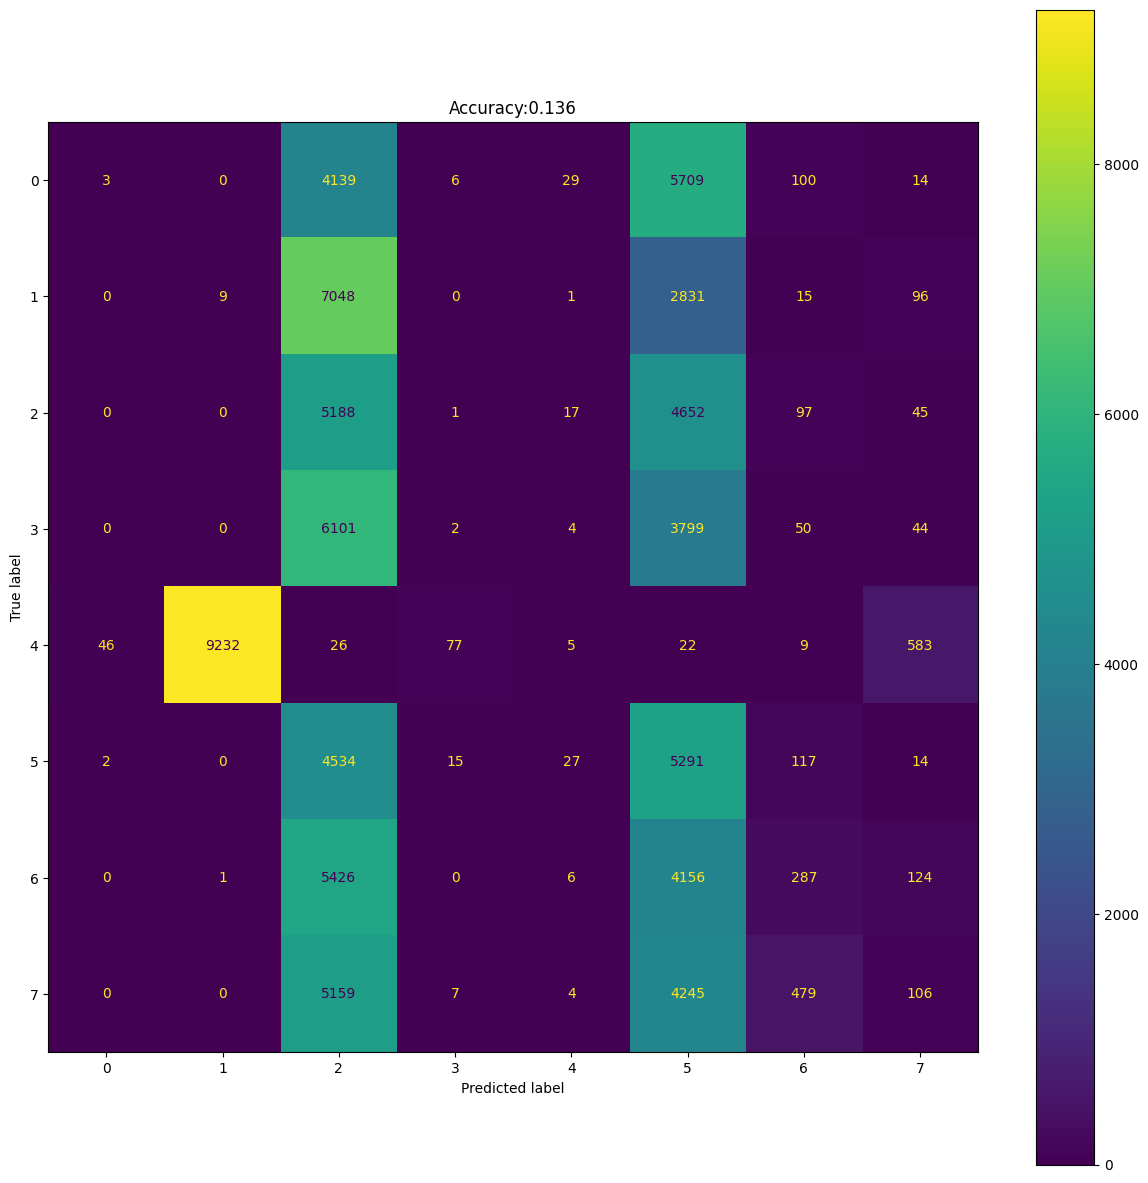

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(v) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.3497 - accuracy: 0.2051
Epoch 2/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.8916 - accuracy: 0.2401
Epoch 3/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.7019 - accuracy: 0.3825
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.6055 - accuracy: 0.4102
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.5462 - accuracy: 0.4253
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.5063 - accuracy: 0.4366
Epoch 7/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4770 - accuracy: 0.4444
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.4550 - accuracy: 0.4513
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4372 - accuracy: 0.4593
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

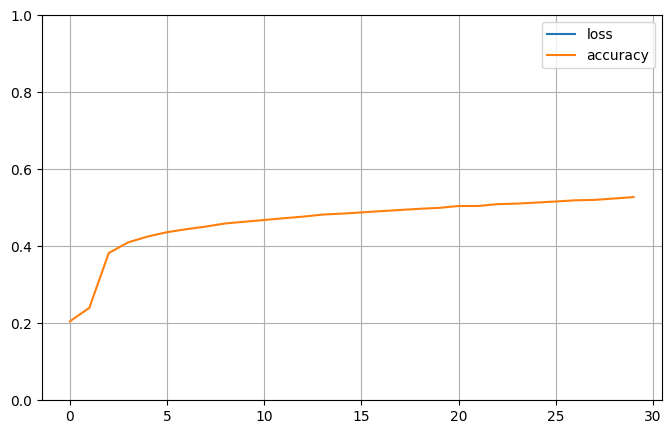

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2822 - accuracy: 0.5307
test loss, test acc: [1.2821731567382812, 0.530662477016449]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[7 5 7 ... 5 2 6]
7
[[3810  547  814 1046    0 1932  618 1233]
 [ 225 7021  289  724   13  440  873  415]
 [1687 1211 1837 1378    0 1503 1249 1135]
 [ 929 1435  477 4154    4 1017 1042  942]
 [  14   13    1    0 9885    2   28   57]
 [2454  684  874 1057    0 3146  591 1194]
 [ 405 1050  416  739    8  424 6071  887]
 [ 904  350  219  653    1  618  726 6529]]
              precision    recall  f1-score   support

           0       0.37      0.38      0.37     10000
           1       0.57      0.70      0.63     10000
           2       0.37      0.18      0.25     10000
           3       0.43      0.42      0.42     10000
           4       1.00      0.99      0.99     10000
           5       0.35      0.31      0.33     10000
           6       0.54      0.61      0.57     10000
           7       0.53      0.65      0.58     10000

    accuracy                           0.53     80000
   macro avg       0.52      0.53  

Test Accuracy:0.5306625


Text(0.5, 1.0, 'Accuracy:0.531')

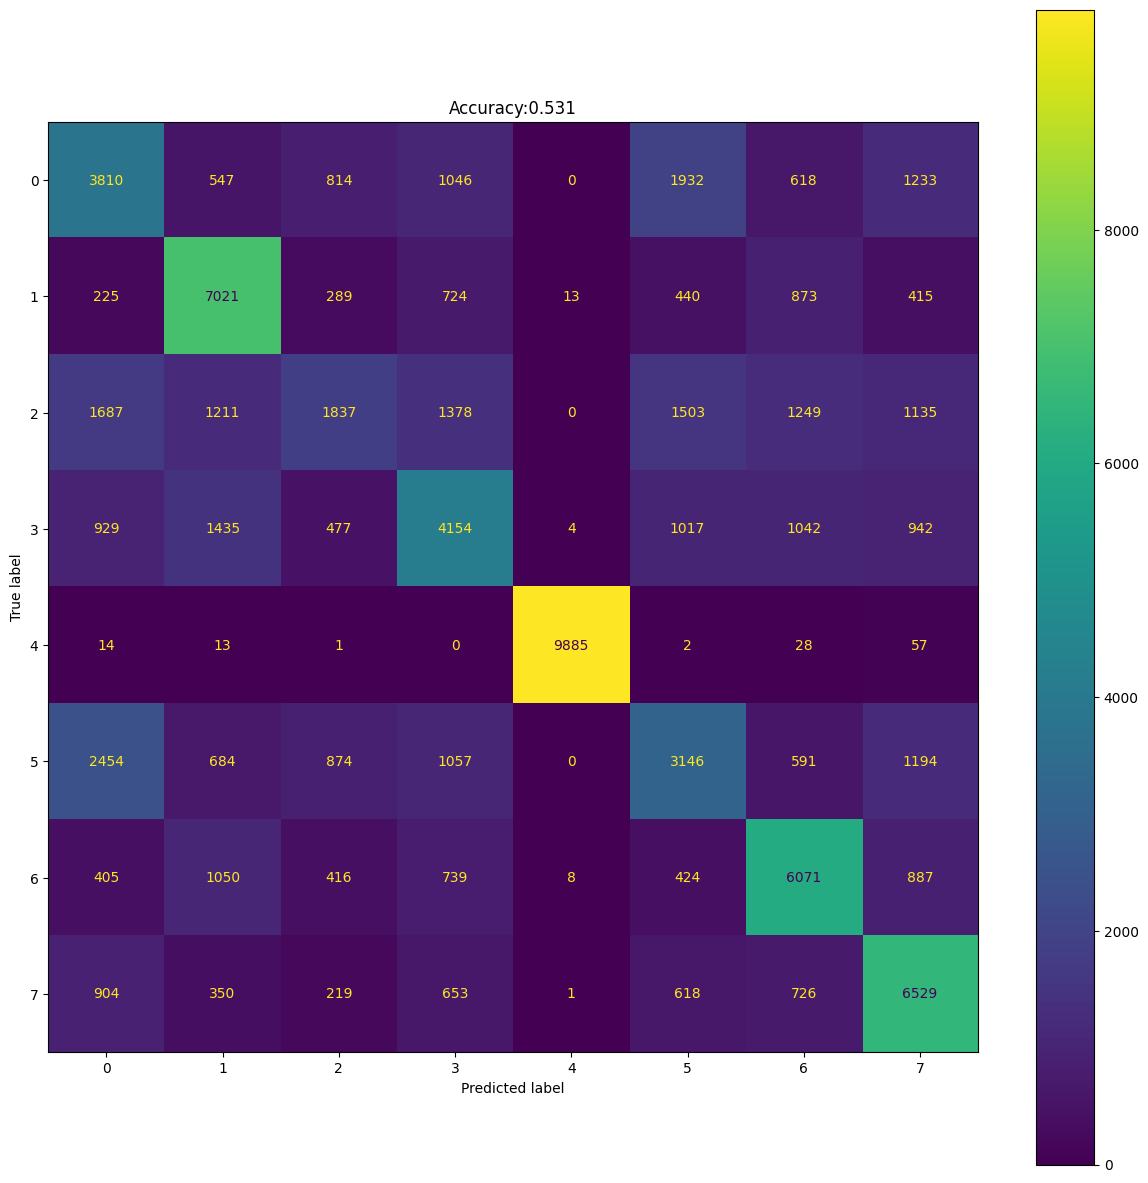

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(v) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.7456 - accuracy: 0.1024
test loss, test acc: [5.745584964752197, 0.1024250015616417]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[5 2 5 ... 2 5 5]
5
[[  27    3 2726    0    1 6705  516   22]
 [   1    0 4411    0    0 4801  735   52]
 [  41    5 2372    0    1 7007  553   21]
 [ 110   34 2224    0    0 6235 1350   47]
 [  63 8904    7   10    0    7  205  804]
 [  17    1 4278    0    0 5161  530   13]
 [ 108    6 2710    0    1 6481  611   83]
 [  12    0 4534    0    0 4971  460   23]]
              precision    recall  f1-score   support

           0       0.07      0.00      0.01     10000
           1       0.00      0.00      0.00     10000
           2       0.10      0.24      0.14     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.12      0.52      0.20     10000
           6       0.12      0.06      0.08     10000
           7       0.02      0.00      0.00     10000

    accuracy                           0.10     80000
   macro avg       0.06      0.10  

Test Accuracy:0.102425


Text(0.5, 1.0, 'Accuracy:0.102')

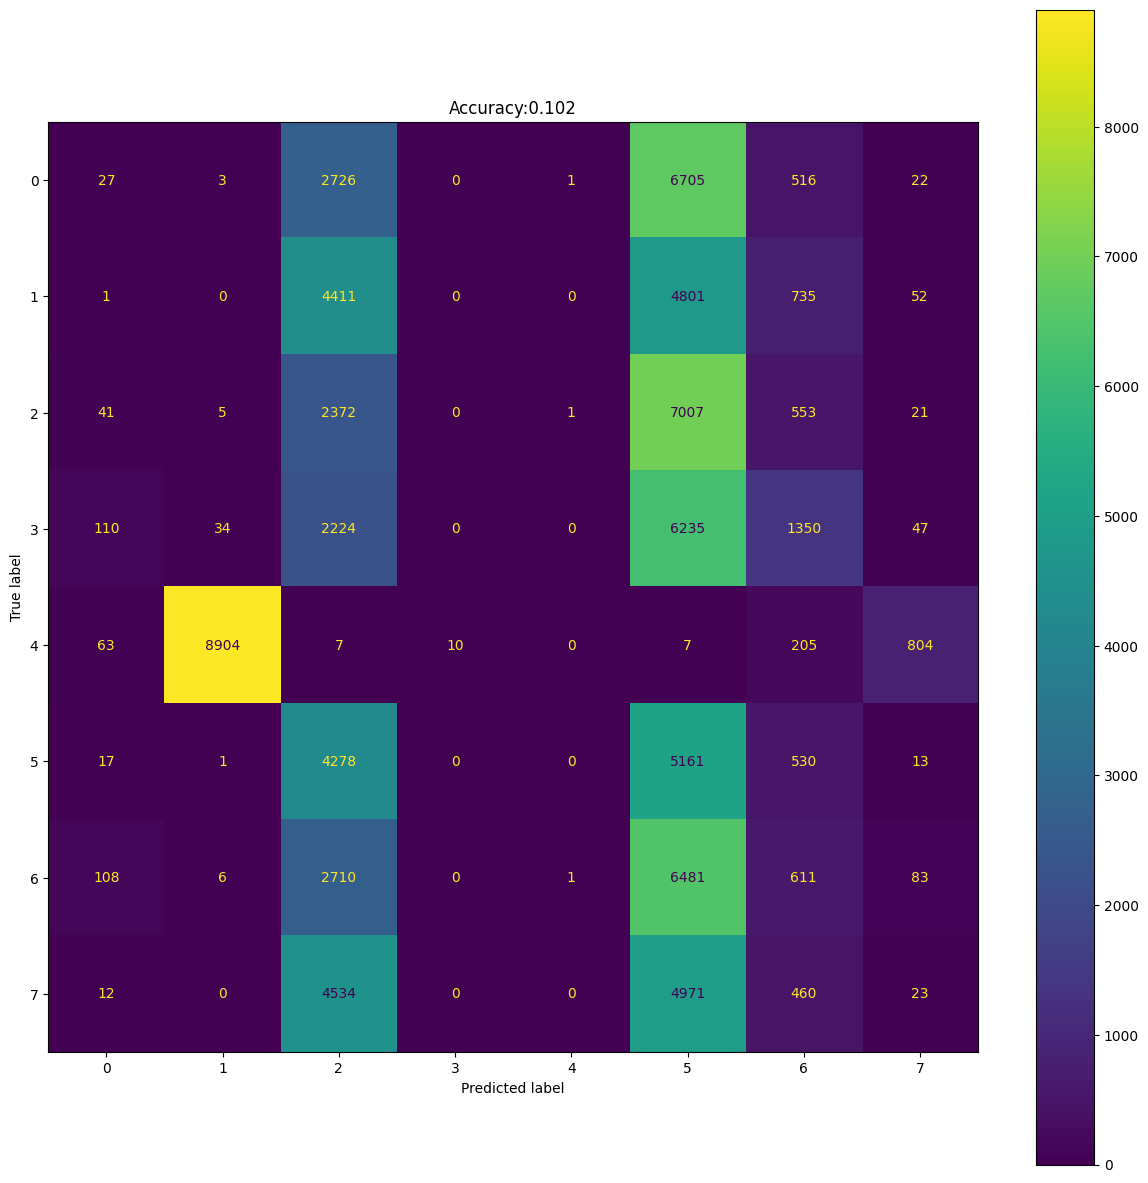

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.8356 - accuracy: 0.1141
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.9254 - accuracy: 0.2551
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.7022 - accuracy: 0.3825
Epoch 4/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.5969 - accuracy: 0.4146
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.5355 - accuracy: 0.4338
Epoch 6/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4955 - accuracy: 0.4449
Epoch 7/30
2500/2500 [==============================] - 18s 7ms/step - loss: 1.4672 - accuracy: 0.4535
Epoch 8/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4455 - accuracy: 0.4603
Epoch 9/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.4282 - accuracy: 0.4684
Epoch 10/30
2500/2500 [==============================] - 14s 5ms/step - l

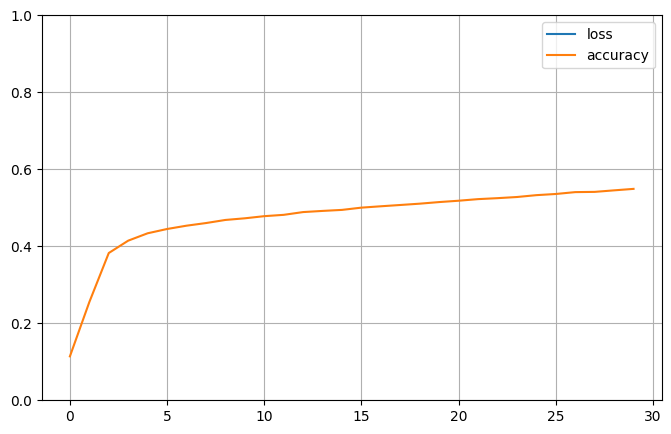

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2637 - accuracy: 0.5428
test loss, test acc: [1.263687252998352, 0.5428125262260437]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 5 3 ... 7 7 7]
6
[[1964  658 1040 2257    2 2320  428 1331]
 [ 116 8014   97  350    1  447  153  822]
 [ 768  603 2213 2672    5 1900  487 1352]
 [ 239  317  551 6666    8 1095  359  765]
 [   0   32    0    2 9946    0    9   11]
 [ 872  729  727 1911    0 3879  281 1601]
 [ 205  648  756 2134   11 1053 4161 1032]
 [ 324  910  381  803    1  808  191 6582]]
              precision    recall  f1-score   support

           0       0.44      0.20      0.27     10000
           1       0.67      0.80      0.73     10000
           2       0.38      0.22      0.28     10000
           3       0.40      0.67      0.50     10000
           4       1.00      0.99      1.00     10000
           5       0.34      0.39      0.36     10000
           6       0.69      0.42      0.52     10000
           7       0.49      0.66      0.56     10000

    accuracy                           0.54     80000
   macro avg       0.55      0.54  

Test Accuracy:0.5428125


Text(0.5, 1.0, 'Accuracy:0.543')

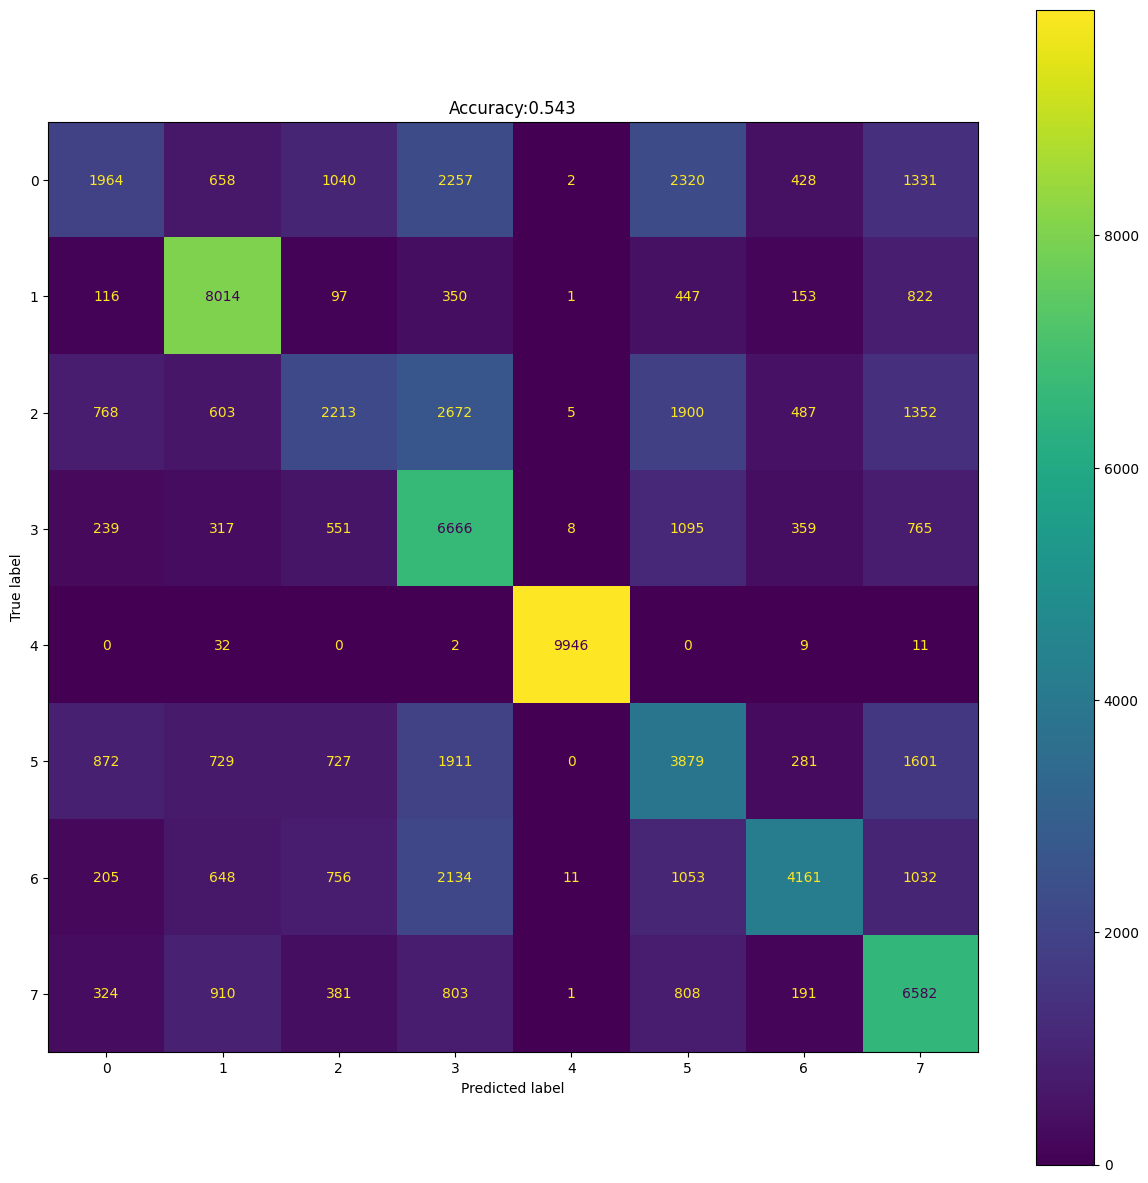

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(v) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 4.4634 - accuracy: 0.1408
test loss, test acc: [4.463369369506836, 0.1407874971628189]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 5 5 ... 5 0 3]
6
[[ 396  108 1473  287  364 6296  959  117]
 [ 349  310  540  616  118 5374 2628   65]
 [ 755   53 1170  229  412 6176 1160   45]
 [2762   16 1638  105  370 4786  288   35]
 [   4 9510  160   86   12    0  145   83]
 [ 332   87  874  329  512 6932  775  159]
 [ 285  255 1729  102   57 5162 2328   82]
 [1200   22  333  238 1112 6733  352   10]]
              precision    recall  f1-score   support

           0       0.07      0.04      0.05     10000
           1       0.03      0.03      0.03     10000
           2       0.15      0.12      0.13     10000
           3       0.05      0.01      0.02     10000
           4       0.00      0.00      0.00     10000
           5       0.17      0.69      0.27     10000
           6       0.27      0.23      0.25     10000
           7       0.02      0.00      0.00     10000

    accuracy                           0.14     80000
   macro avg       0.09      0.14  

Test Accuracy:0.1407875


Text(0.5, 1.0, 'Accuracy:0.141')

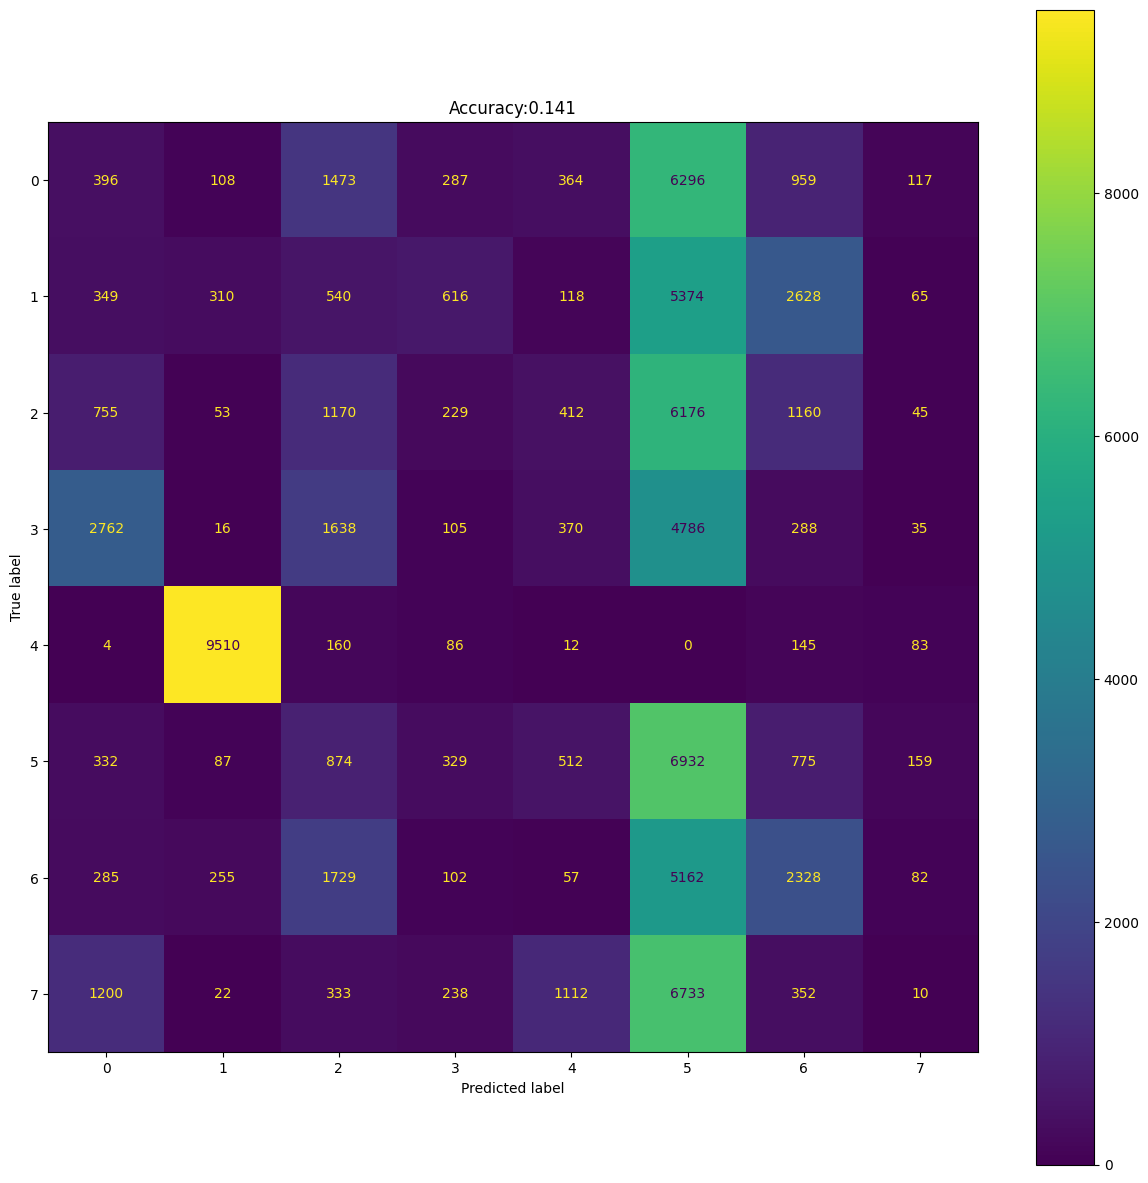

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iii) model to Nordic Device-30(v) dataset 

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.9052 - accuracy: 0.1512
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.0162 - accuracy: 0.2304
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7363 - accuracy: 0.3437
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.6033 - accuracy: 0.4375
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5258 - accuracy: 0.4546
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4758 - accuracy: 0.4667
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4411 - accuracy: 0.4751
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4152 - accuracy: 0.4821
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3949 - accuracy: 0.4881
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

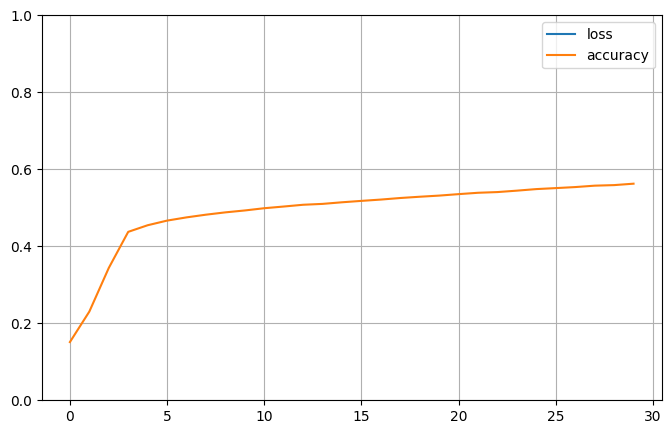

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 1.2174 - accuracy: 0.5659
test loss, test acc: [1.2173994779586792, 0.5659375190734863]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[6 3 5 ... 7 7 5]
6
[[2917  814 1099 1393    7 1484 1277 1009]
 [ 260 6835  397  466   15  383  969  675]
 [1350  896 2303 1545    1 1358 1216 1331]
 [ 715  244  458 6585    2  434  626  936]
 [   0    3    0   25 9950    0   17    5]
 [1612  859 1117 1082    2 3099  918 1311]
 [ 387  877  552  661   15  438 6736  334]
 [ 447  586  402  784    0  655  276 6850]]
              precision    recall  f1-score   support

           0       0.38      0.29      0.33     10000
           1       0.61      0.68      0.65     10000
           2       0.36      0.23      0.28     10000
           3       0.53      0.66      0.58     10000
           4       1.00      0.99      1.00     10000
           5       0.39      0.31      0.35     10000
           6       0.56      0.67      0.61     10000
           7       0.55      0.69      0.61     10000

    accuracy                           0.57     80000
   macro avg       0.55      0.57  

Test Accuracy:0.5659375


Text(0.5, 1.0, 'Accuracy:0.566')

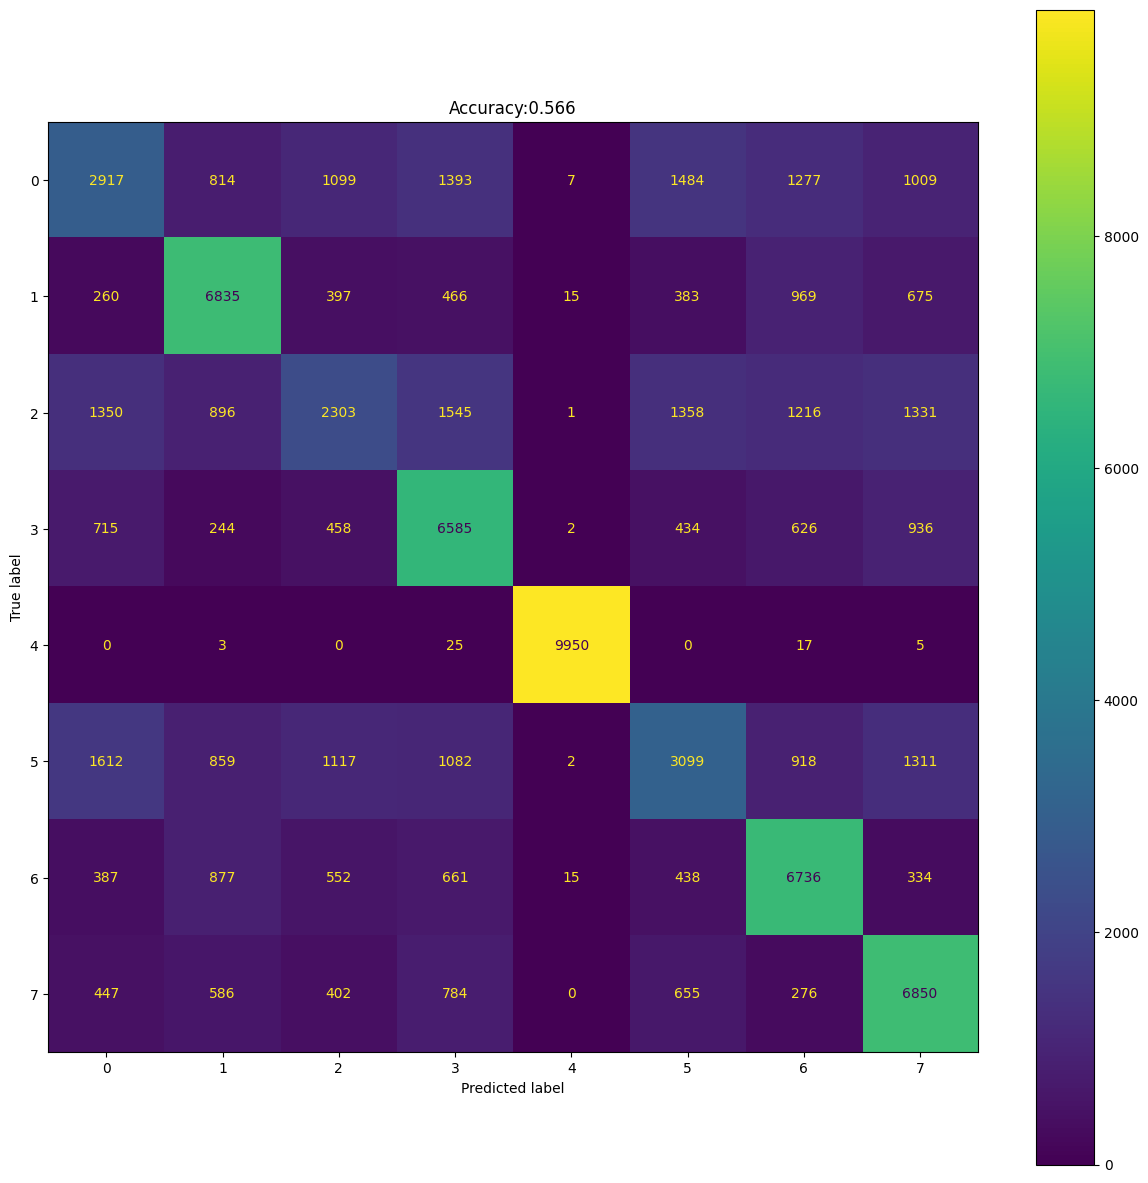

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-30(v) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 14s 5ms/step - loss: 4.6776 - accuracy: 0.1184
test loss, test acc: [4.6775712966918945, 0.11838749796152115]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 0 5 ... 5 0 0]
6
[[1251   13  822  106  655 6139  860  154]
 [2236   18  346  111  409 5748  953  179]
 [1497   11  482  117  752 5743 1167  231]
 [3477    4  270   35 1452 4378  220  164]
 [9647   21   14   95   16   58  145    4]
 [1274   12  814  125  849 5846  792  288]
 [2589   11  225   38  333 4819 1821  164]
 [1727  188  789  179  239 6412  464    2]]
              precision    recall  f1-score   support

           0       0.05      0.13      0.07     10000
           1       0.06      0.00      0.00     10000
           2       0.13      0.05      0.07     10000
           3       0.04      0.00      0.01     10000
           4       0.00      0.00      0.00     10000
           5       0.15      0.58      0.24     10000
           6       0.28      0.18      0.22     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.09      0.12  

Test Accuracy:0.1183875


Text(0.5, 1.0, 'Accuracy:0.118')

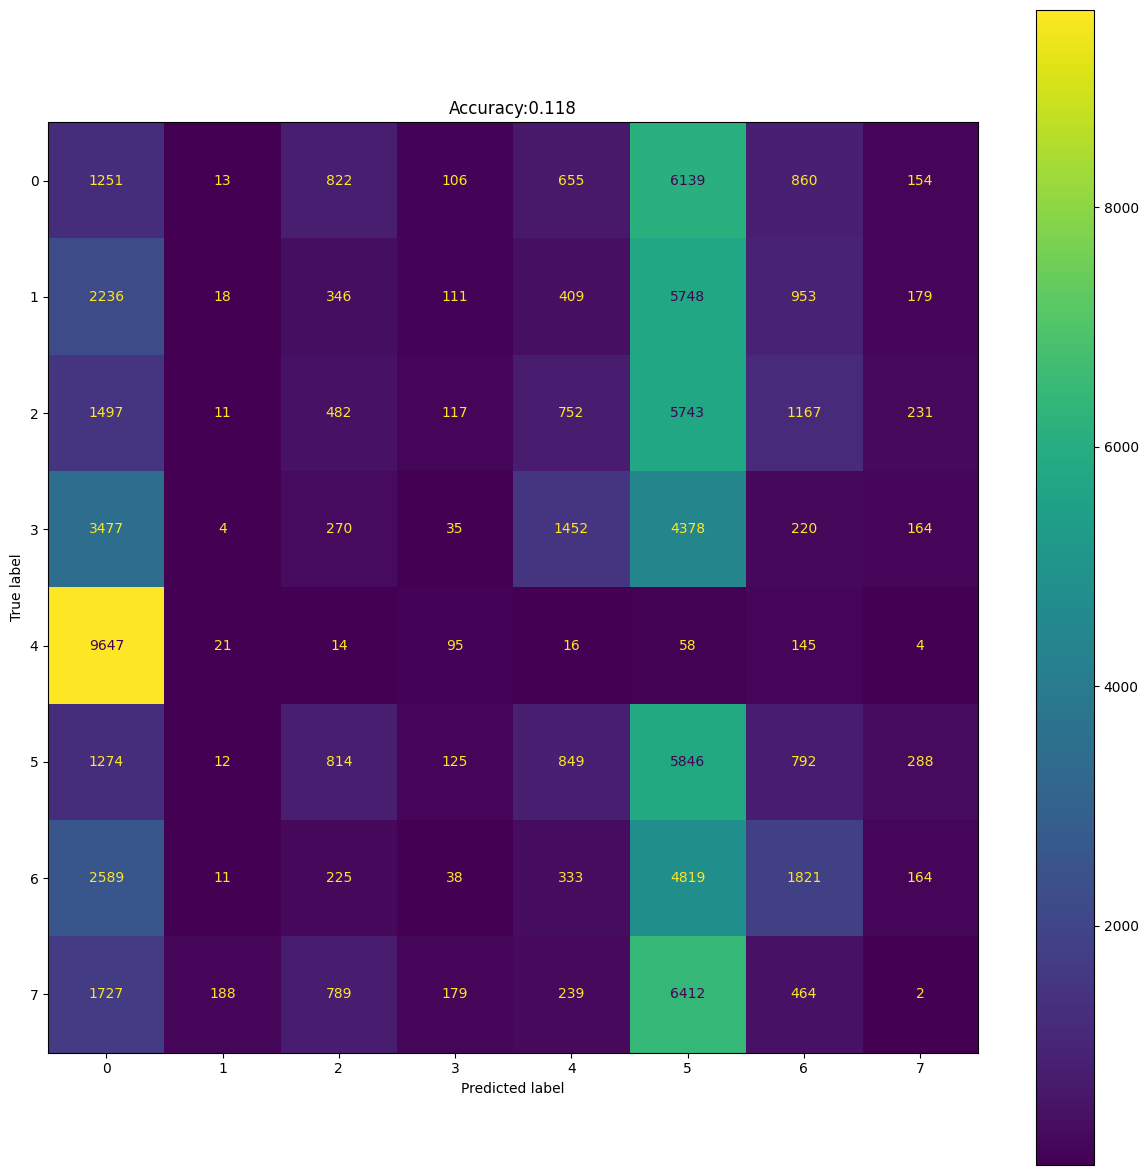

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 15s 6ms/step - loss: 2.9677 - accuracy: 0.1260
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.0239 - accuracy: 0.2746
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7204 - accuracy: 0.4014
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.5979 - accuracy: 0.4374
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.5315 - accuracy: 0.4532
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4887 - accuracy: 0.4645
Epoch 7/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.4578 - accuracy: 0.4742
Epoch 8/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4341 - accuracy: 0.4794
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4156 - accuracy: 0.4845
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

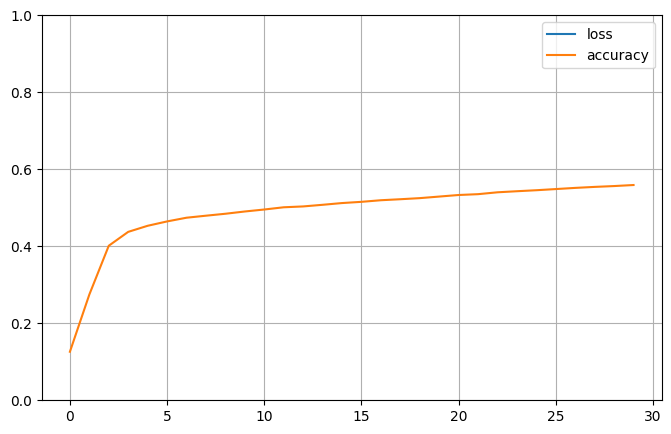

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2487 - accuracy: 0.5568
test loss, test acc: [1.2486907243728638, 0.5568374991416931]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 6 1 ... 7 7 7]
6
[[1650  477  719 1266    4 3420 1387 1077]
 [ 241 5440  196  955   14 1006 1262  886]
 [ 743  540 2099 1156    7 2800 1850  805]
 [ 371  243  261 6195   35 1495  826  574]
 [   0   24    0   11 9879    2   48   36]
 [ 759  489  707 1342    4 4781 1002  916]
 [ 326  445  455  796   13  816 6656  493]
 [ 254  410  134  452   19  638  246 7847]]
              precision    recall  f1-score   support

           0       0.38      0.17      0.23     10000
           1       0.67      0.54      0.60     10000
           2       0.46      0.21      0.29     10000
           3       0.51      0.62      0.56     10000
           4       0.99      0.99      0.99     10000
           5       0.32      0.48      0.38     10000
           6       0.50      0.67      0.57     10000
           7       0.62      0.78      0.69     10000

    accuracy                           0.56     80000
   macro avg       0.56      0.56  

Test Accuracy:0.5568375


Text(0.5, 1.0, 'Accuracy:0.557')

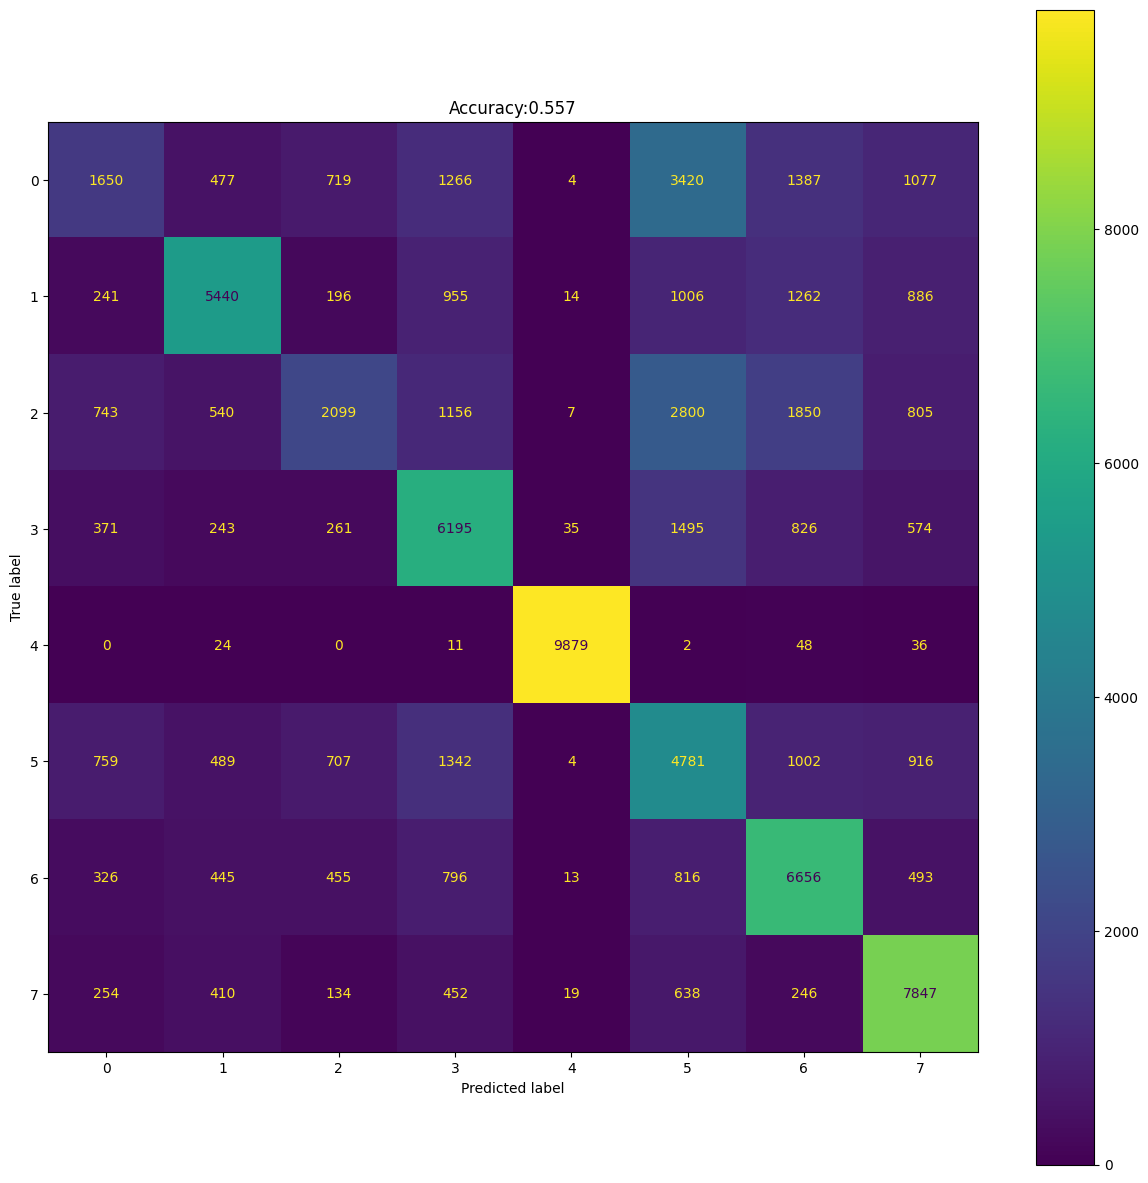

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-30(v) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 5.1917 - accuracy: 0.1123
test loss, test acc: [5.191699981689453, 0.11226250231266022]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 5ms/step
[2 5 5 ... 5 0 0]
2
[[ 259   20 1409  183  729 7256  105   39]
 [ 127  154 1649  313  689 6929   50   89]
 [ 131    5 1055  135  401 8182   64   27]
 [2084    2  843   65 2060 4923   18    5]
 [  47 3712   11   10  198   11   99 5912]
 [ 247   16 1500  235  848 7069   39   46]
 [ 422    9 1805   71  796 6691  180   26]
 [1208   11 1253   37  264 6785  441    1]]
              precision    recall  f1-score   support

           0       0.06      0.03      0.04     10000
           1       0.04      0.02      0.02     10000
           2       0.11      0.11      0.11     10000
           3       0.06      0.01      0.01     10000
           4       0.03      0.02      0.02     10000
           5       0.15      0.71      0.24     10000
           6       0.18      0.02      0.03     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.11     80000
   macro avg       0.08      0.11  

Test Accuracy:0.1122625


Text(0.5, 1.0, 'Accuracy:0.112')

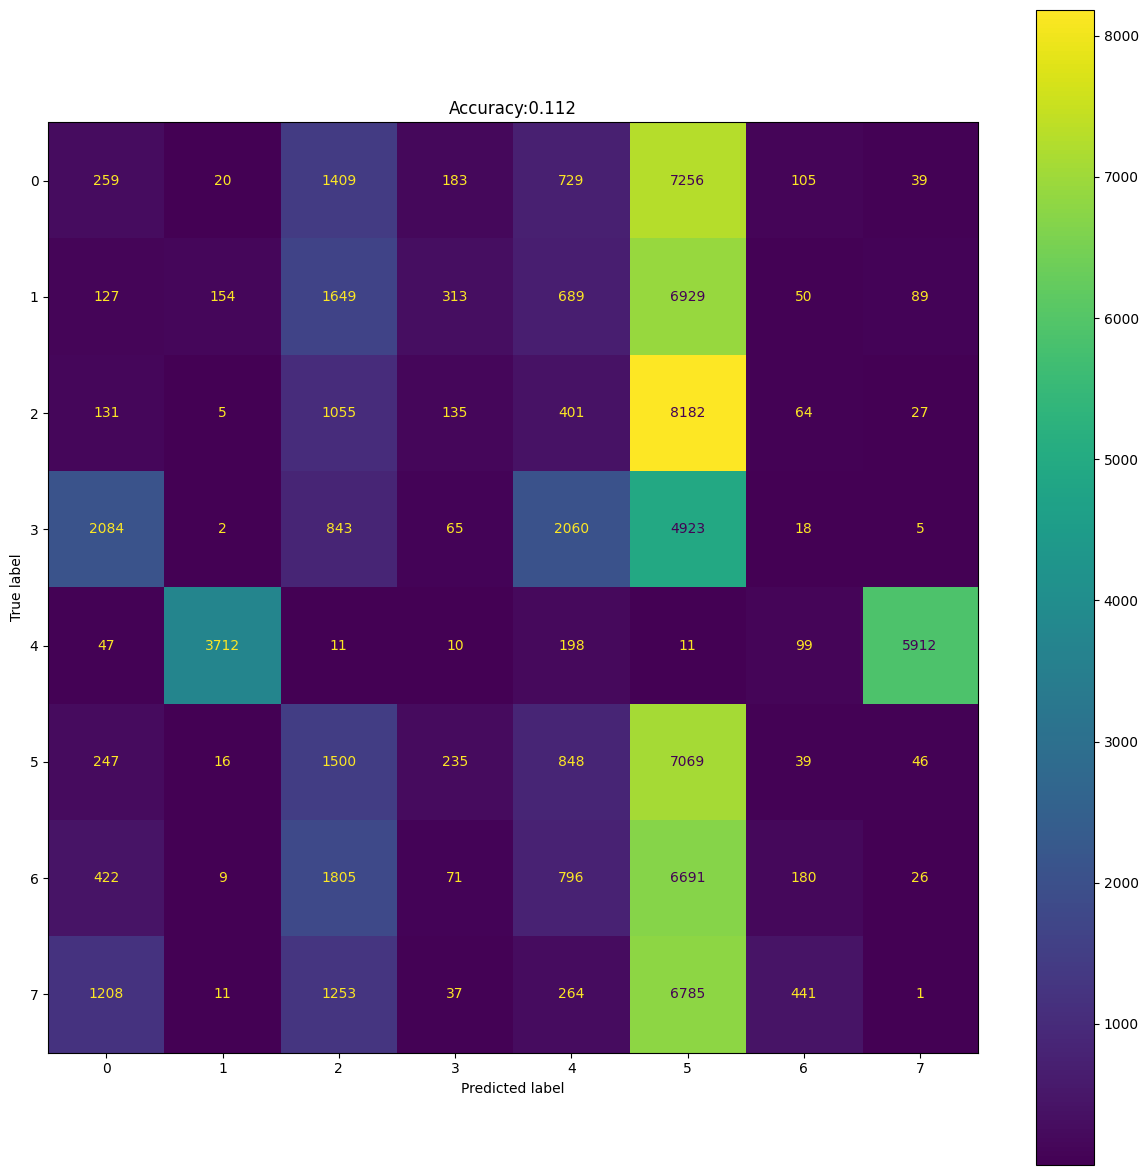

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-30(v) dataset 

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.8630 - accuracy: 0.1613
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.9002 - accuracy: 0.3123
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.6998 - accuracy: 0.3918
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6091 - accuracy: 0.4198
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.5511 - accuracy: 0.4404
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.5081 - accuracy: 0.4552
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4738 - accuracy: 0.4687
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.4453 - accuracy: 0.4796
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.4213 - accuracy: 0.4894
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

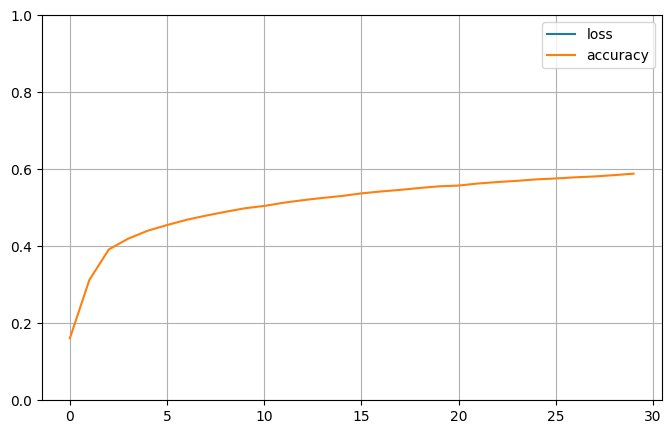

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1983 - accuracy: 0.5881
test loss, test acc: [1.198337197303772, 0.588100016117096]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 7 2 ... 7 7 7]
6
[[1297  775 1645 1029   14 3395  595 1250]
 [  94 7989  383  302   16  369  417  430]
 [ 446  607 3971  910    3 2251  863  949]
 [ 119  118  706 6939    2 1127  385  604]
 [   0    3    0    4 9976    0   17    0]
 [ 475  834 1239 1215    9 4868  526  834]
 [  97  676 1068 1016   21  822 5768  532]
 [ 259  397  481  950   18 1132  523 6240]]
              precision    recall  f1-score   support

           0       0.47      0.13      0.20     10000
           1       0.70      0.80      0.75     10000
           2       0.42      0.40      0.41     10000
           3       0.56      0.69      0.62     10000
           4       0.99      1.00      0.99     10000
           5       0.35      0.49      0.41     10000
           6       0.63      0.58      0.60     10000
           7       0.58      0.62      0.60     10000

    accuracy                           0.59     80000
   macro avg       0.59      0.59  

Test Accuracy:0.5881


Text(0.5, 1.0, 'Accuracy:0.588')

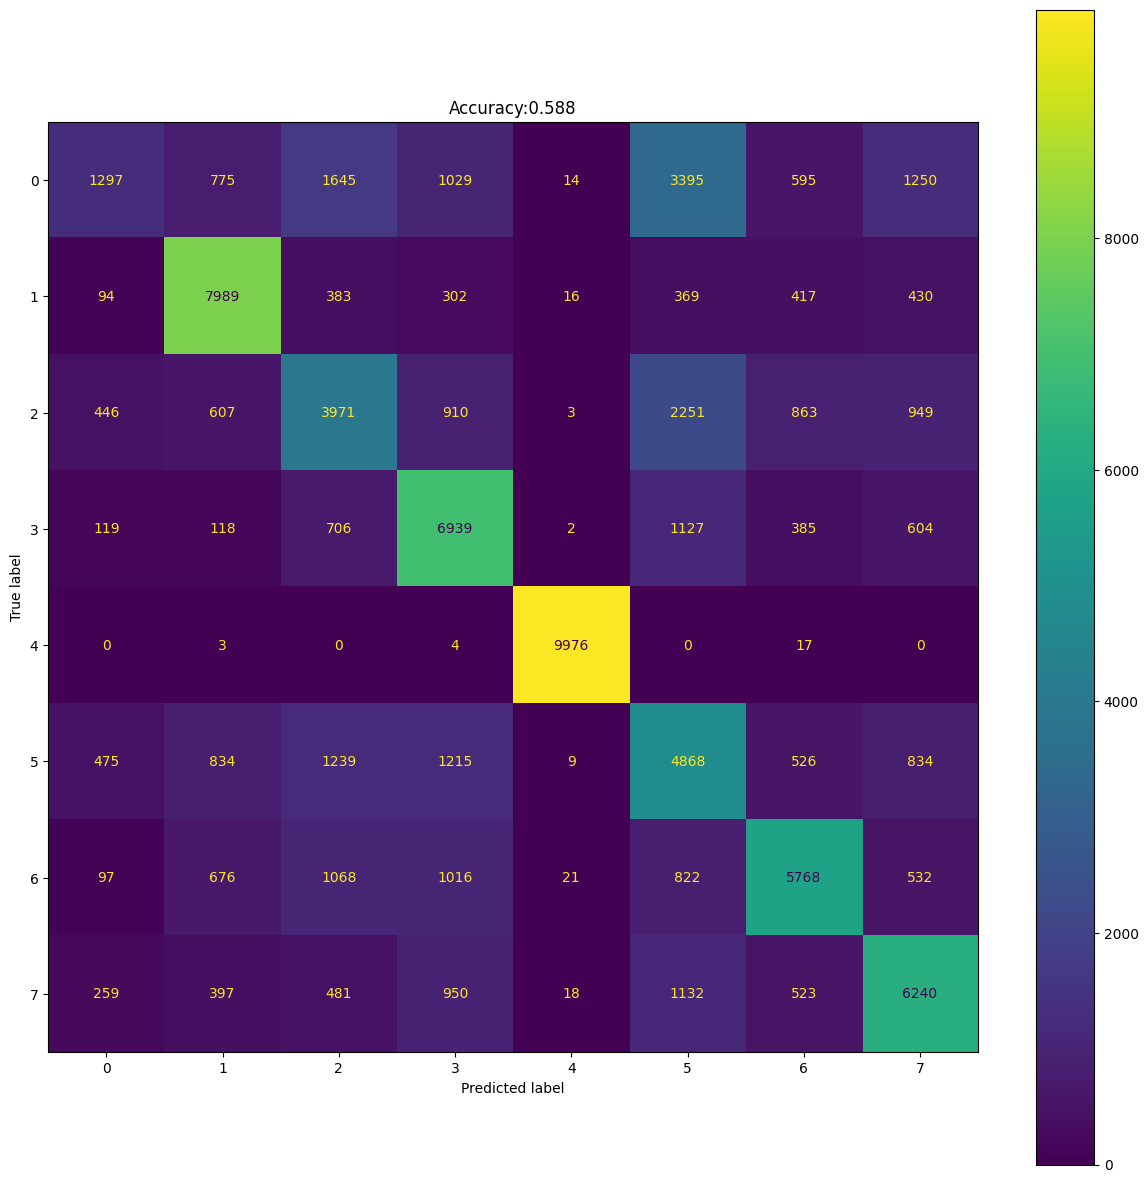

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(i) model to Nordic Device-30(v) dataset 

In [59]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [60]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 6.0020 - accuracy: 0.1324
test loss, test acc: [6.001992225646973, 0.13237500190734863]


In [61]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[6 2 2 ... 2 2 6]
6
[[   0    0 7761    6    0  672 1558    3]
 [   0    0 9126    1    0   16  689  168]
 [   0    0 7119    3    0  802 2076    0]
 [   0    0 7660    0    0  522 1818    0]
 [  64 9647   21  100   23    2   59   84]
 [   0    0 7549    1    0  589 1861    0]
 [   0    0 6185   92    0  839 2859   25]
 [   0    0 6102    0    0  651 3247    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.14      0.71      0.23     10000
           3       0.00      0.00      0.00     10000
           4       1.00      0.00      0.00     10000
           5       0.14      0.06      0.08     10000
           6       0.20      0.29      0.24     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.19      0.13  

Test Accuracy:0.132375


Text(0.5, 1.0, 'Accuracy:0.132')

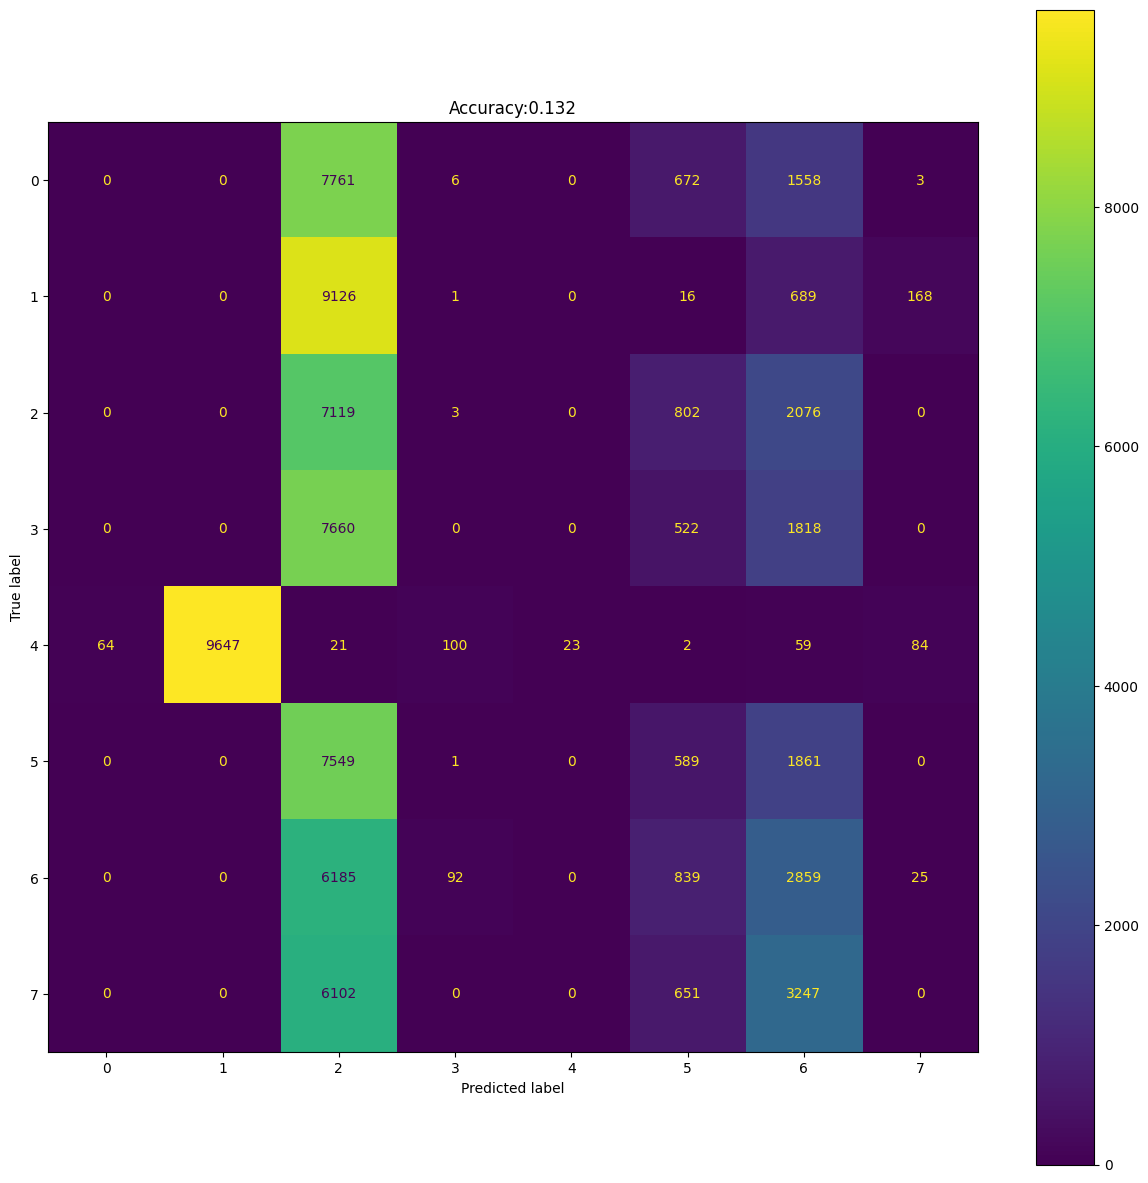

In [62]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [63]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [64]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [65]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.5267 - accuracy: 0.1775
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.7896 - accuracy: 0.2708
Epoch 3/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.5607 - accuracy: 0.4309
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4580 - accuracy: 0.4579
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.4029 - accuracy: 0.4742
Epoch 6/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3683 - accuracy: 0.4855
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3432 - accuracy: 0.4947
Epoch 8/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.3229 - accuracy: 0.5025
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.3058 - accuracy: 0.5084
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

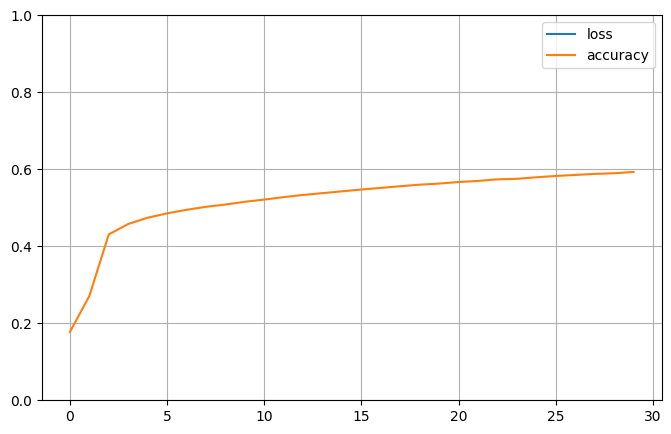

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [67]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1285 - accuracy: 0.5970
test loss, test acc: [1.1285005807876587, 0.597000002861023]


In [68]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[7 5 3 ... 0 2 7]
7
[[3668  442  990 1460    1 1388 1179  872]
 [  89 8882  100  274    2  339  178  136]
 [2286  471 2064 1324    0 1329 1343 1183]
 [1073  549  436 5582    1  599  956  804]
 [   0    0    0    3 9876    0   58   63]
 [2045  753  832 1199    0 2909  924 1338]
 [ 320  270  352  685    7  109 8109  148]
 [ 860  317  469  556    0  617  511 6670]]
              precision    recall  f1-score   support

           0       0.35      0.37      0.36     10000
           1       0.76      0.89      0.82     10000
           2       0.39      0.21      0.27     10000
           3       0.50      0.56      0.53     10000
           4       1.00      0.99      0.99     10000
           5       0.40      0.29      0.34     10000
           6       0.61      0.81      0.70     10000
           7       0.59      0.67      0.63     10000

    accuracy                           0.60     80000
   macro avg       0.58      0.60  

Test Accuracy:0.597


Text(0.5, 1.0, 'Accuracy:0.597')

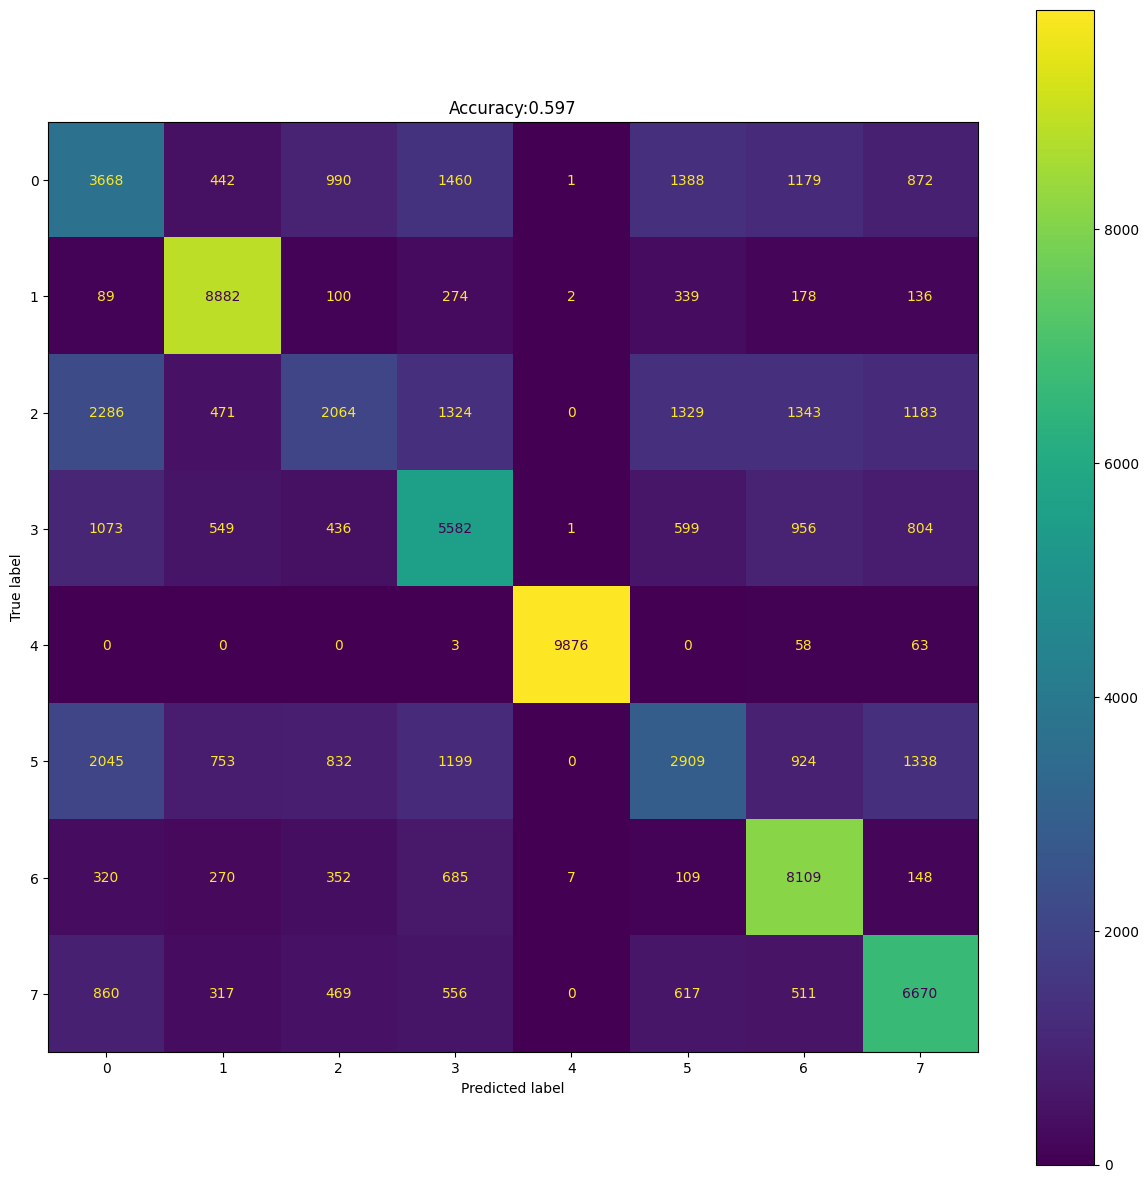

In [69]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-30(v) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

2023-04-16 17:44:58.299971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.9058 - accuracy: 0.1609
test loss, test acc: [5.905782222747803, 0.1609250009059906]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 5 6 5]
5
[[  13    3 3136    2    0 6240  601    5]
 [   1  109 2086   19    0 6256 1343  186]
 [  25    1 3044    2    0 5651 1271    6]
 [  21    1 2894    0    0 6188  893    3]
 [  37  116   47   56   47   28  118 9551]
 [  16    2 2332    1    0 6863  782    4]
 [   7   30 2378   68    0 4672 2798   47]
 [  70    0 3179    1    0 5113 1637    0]]
              precision    recall  f1-score   support

           0       0.07      0.00      0.00     10000
           1       0.42      0.01      0.02     10000
           2       0.16      0.30      0.21     10000
           3       0.00      0.00      0.00     10000
           4       1.00      0.00      0.01     10000
           5       0.17      0.69      0.27     10000
           6       0.30      0.28      0.29     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.16     80000
   macro avg       0.26      0.16  

Test Accuracy:0.160925


Text(0.5, 1.0, 'Accuracy:0.161')

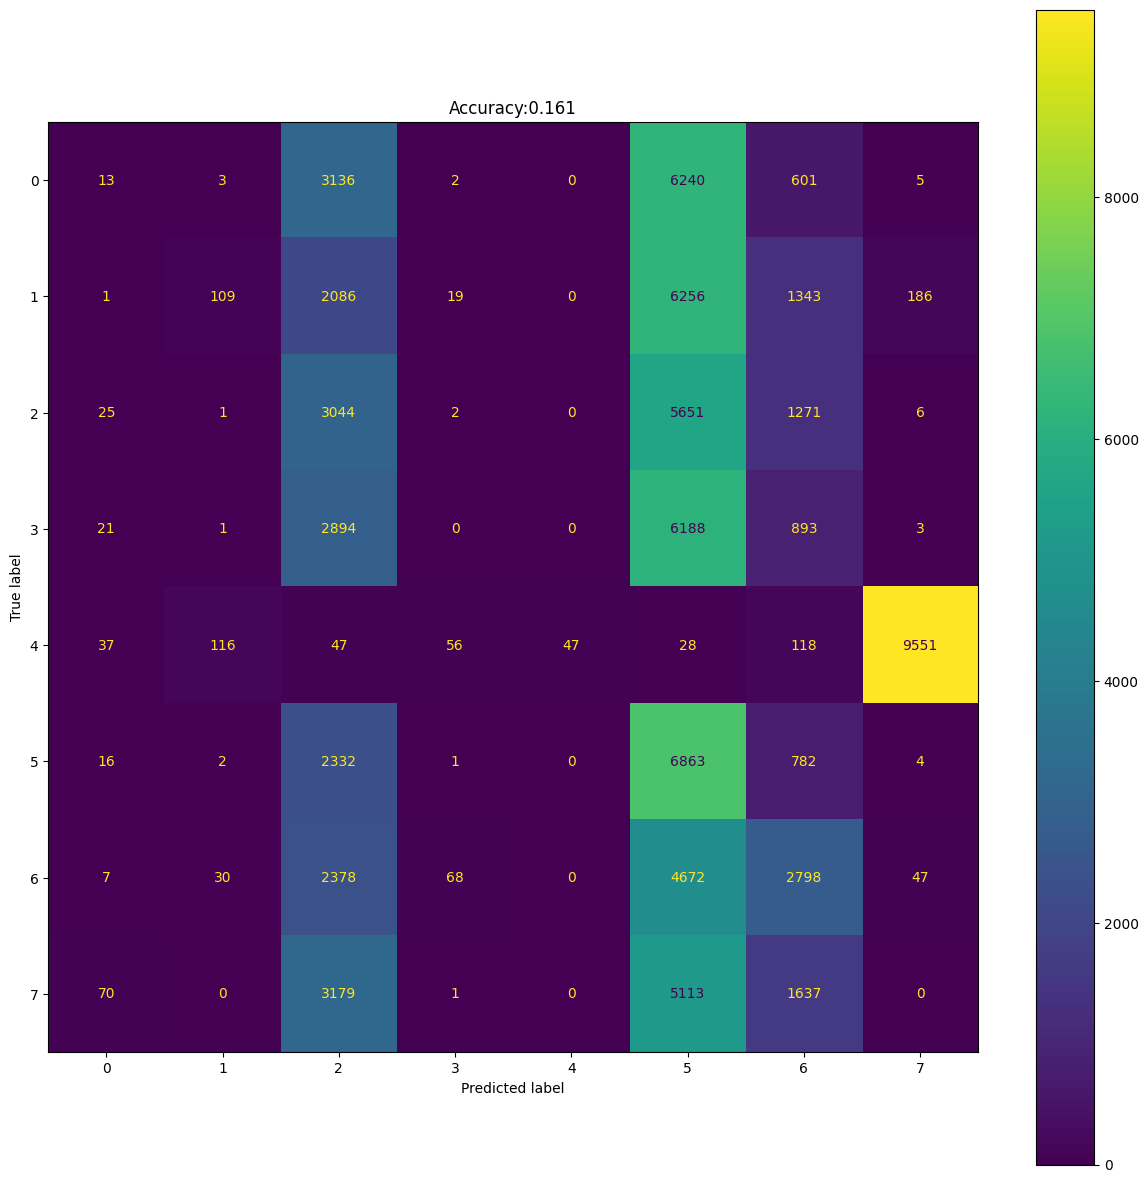

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6917 - accuracy: 0.1765
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9599 - accuracy: 0.2423
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7261 - accuracy: 0.3600
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6211 - accuracy: 0.3847
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5640 - accuracy: 0.4038
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5255 - accuracy: 0.4206
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4965 - accuracy: 0.4339
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4734 - accuracy: 0.4448
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4530 - accuracy: 0.4544
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - lo

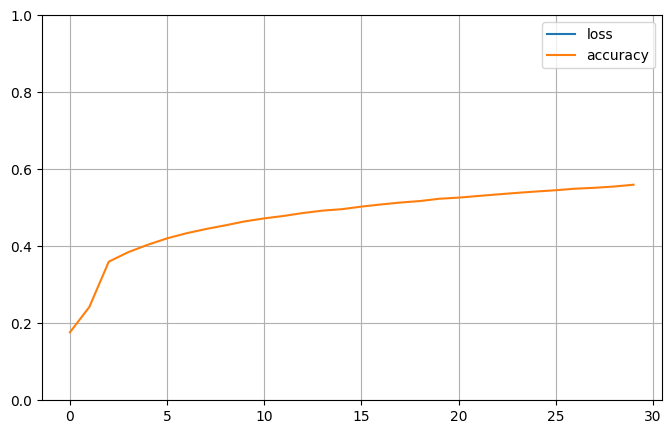

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.2442 - accuracy: 0.5638
test loss, test acc: [1.244236707687378, 0.5637500286102295]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 0 3 ... 6 7 7]
5
[[3786  600  741 1730    0 1852  734  557]
 [ 490 7041  235  860   19  364  790  201]
 [1924  541 1669 2187    1 1547 1179  952]
 [ 804  452  378 6841    0  560  415  550]
 [   0    0    0    4 9809    0   93   94]
 [1952  692  698 2032    1 3218  694  713]
 [ 583 1071  517  739   17  510 6113  450]
 [ 551  266  284 1114    0  640  522 6623]]
              precision    recall  f1-score   support

           0       0.38      0.38      0.38     10000
           1       0.66      0.70      0.68     10000
           2       0.37      0.17      0.23     10000
           3       0.44      0.68      0.54     10000
           4       1.00      0.98      0.99     10000
           5       0.37      0.32      0.34     10000
           6       0.58      0.61      0.60     10000
           7       0.65      0.66      0.66     10000

    accuracy                           0.56     80000
   macro avg       0.56      0.56  

Test Accuracy:0.56375


Text(0.5, 1.0, 'Accuracy:0.564')

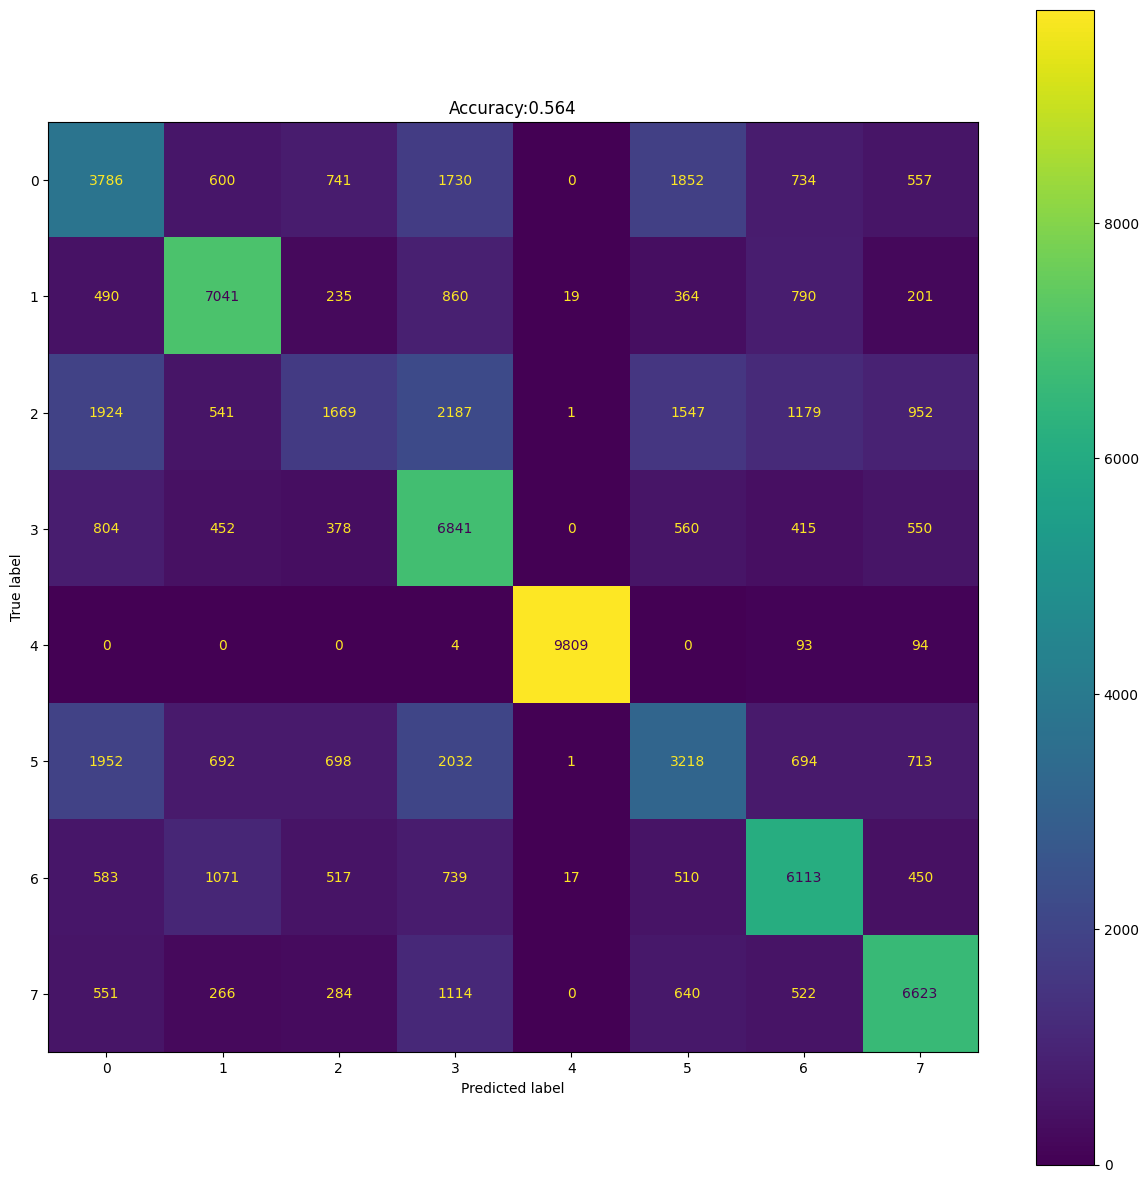

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-30(v) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.5210 - accuracy: 0.6085
test loss, test acc: [1.5209568738937378, 0.6084625124931335]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 4 4 ... 7 7 7]
3
[[  51   26 2711  365 2555 3910  118  264]
 [   0 9971   17    0    2   10    0    0]
 [   5   16 5613  227  560 2947  543   89]
 [   0    0   22 9935    4   24   15    0]
 [9659   44    4   38  120   26   80   29]
 [  12   39 3397  234 1757 4159  191  211]
 [   0    3  762   50   89  176 8916    4]
 [   2    0   29    7   16   28    6 9912]]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01     10000
           1       0.99      1.00      0.99     10000
           2       0.45      0.56      0.50     10000
           3       0.92      0.99      0.95     10000
           4       0.02      0.01      0.02     10000
           5       0.37      0.42      0.39     10000
           6       0.90      0.89      0.90     10000
           7       0.94      0.99      0.97     10000

    accuracy                           0.61     80000
   macro avg       0.57      0.61  

Test Accuracy:0.6084625


Text(0.5, 1.0, 'Accuracy:0.608')

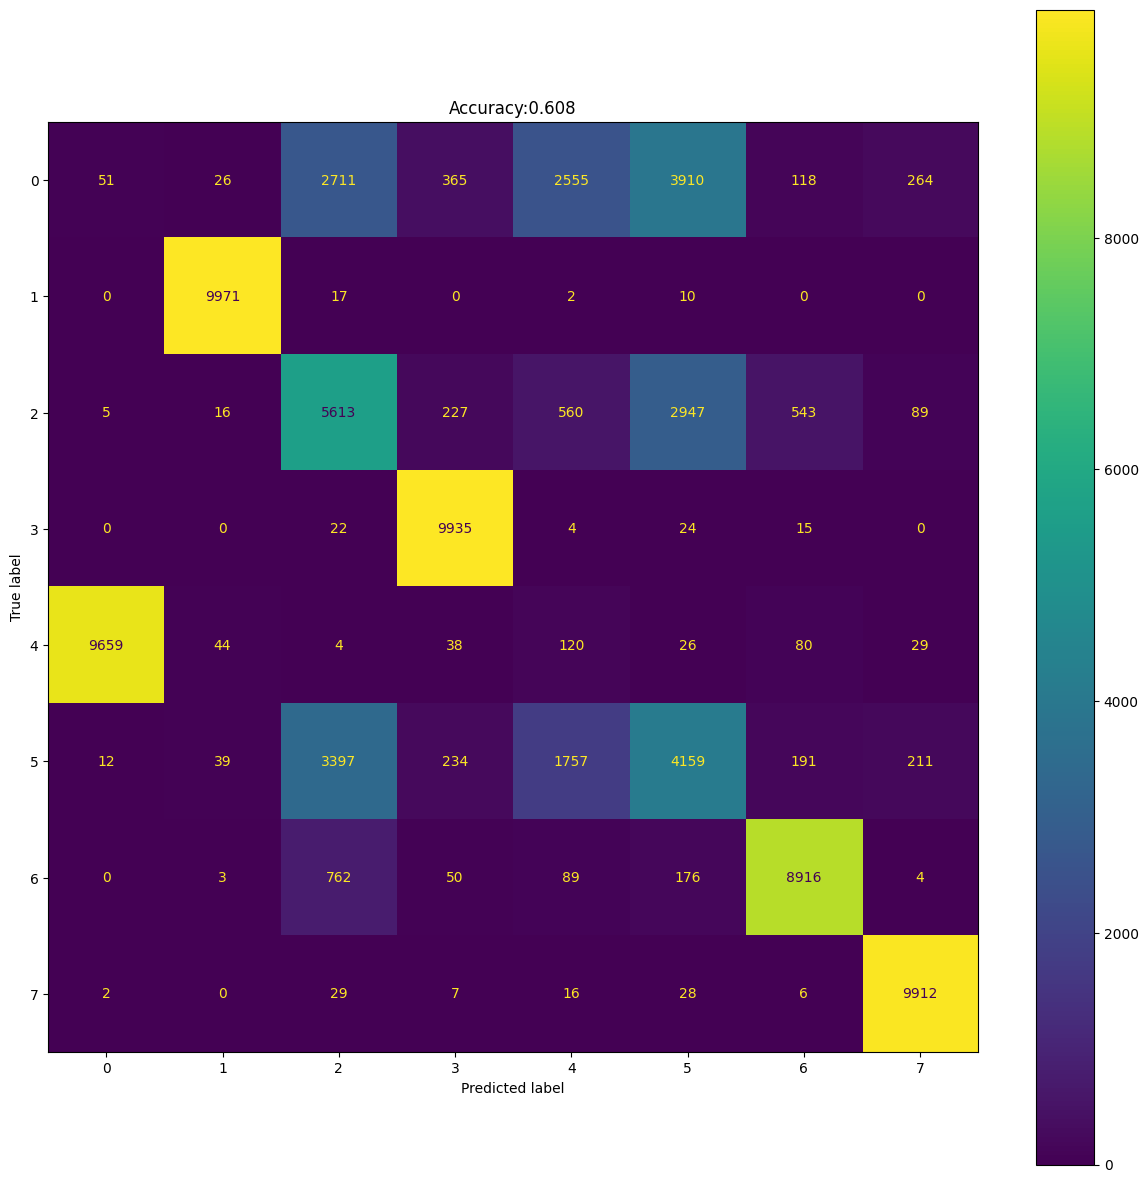

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.8971 - accuracy: 0.6745
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.7016 - accuracy: 0.7775
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6037 - accuracy: 0.7864
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5522 - accuracy: 0.7922
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5236 - accuracy: 0.7966
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5057 - accuracy: 0.8005
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4931 - accuracy: 0.8037
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4838 - accuracy: 0.8057
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4762 - accuracy: 0.8083
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss

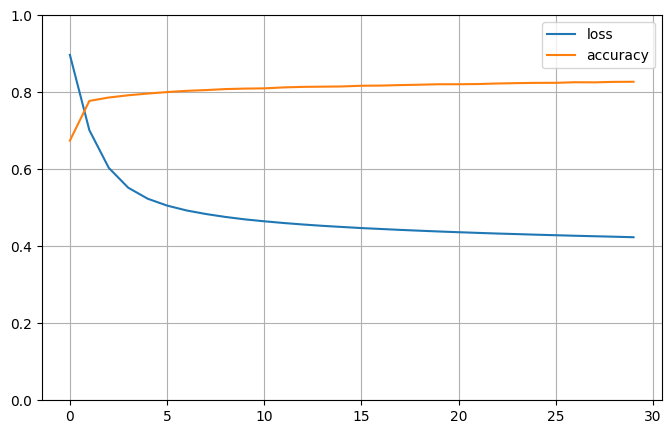

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.4233 - accuracy: 0.8286
test loss, test acc: [0.4232957661151886, 0.8286499977111816]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 5 0 ... 7 7 7]
0
[[5806    1 2039   33   40 1974   79   28]
 [   2 9951   16    0    5   26    0    0]
 [1011    1 7101   29    1 1427  420   10]
 [  13    0   47 9905    1    9   25    0]
 [   0    6    3    6 9879    2   79   25]
 [2647    2 2973   28    8 4202  117   23]
 [  47    0  361    8    0   35 9548    1]
 [  48    0   27    4    2   16    3 9900]]
              precision    recall  f1-score   support

           0       0.61      0.58      0.59     10000
           1       1.00      1.00      1.00     10000
           2       0.57      0.71      0.63     10000
           3       0.99      0.99      0.99     10000
           4       0.99      0.99      0.99     10000
           5       0.55      0.42      0.48     10000
           6       0.93      0.95      0.94     10000
           7       0.99      0.99      0.99     10000

    accuracy                           0.83     80000
   macro avg       0.83      0.83  

Test Accuracy:0.82865


Text(0.5, 1.0, 'Accuracy:0.829')

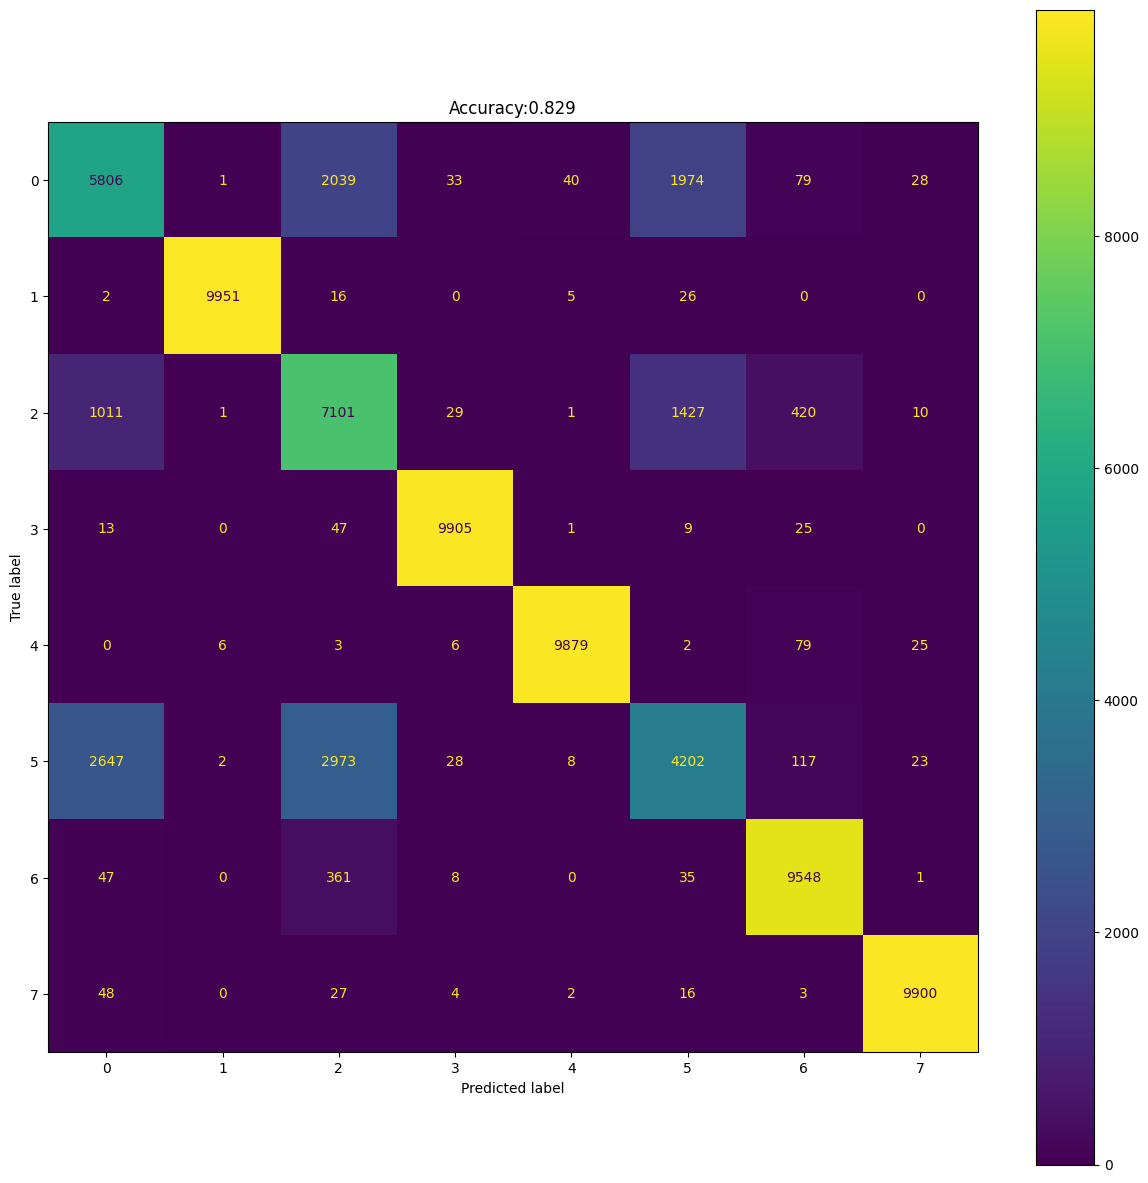

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-30(v) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.5104 - accuracy: 0.8510
test loss, test acc: [0.5103657245635986, 0.8510000109672546]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 0 ... 7 7 7]
5
[[ 3444     0   516    13     0  6026     1     0]
 [    0  9962     7     0     0    27     4     0]
 [  345     0  6028    57     0  3340   230     0]
 [   13     0    39  9864     0    80     4     0]
 [    0     0     0     0 10000     0     0     0]
 [  574     0   217    26     0  9169    13     1]
 [   10     0   264     1     0    48  9677     0]
 [    1     0     1     0     0    60     2  9936]]
              precision    recall  f1-score   support

           0       0.79      0.34      0.48     10000
           1       1.00      1.00      1.00     10000
           2       0.85      0.60      0.71     10000
           3       0.99      0.99      0.99     10000
           4       1.00      1.00      1.00     10000
           5       0.49      0.92      0.64     10000
           6       0.97      0.97      0.97     10000
           7       1.00      0.99      1.00     10000

    accuracy             

Test Accuracy:0.851


Text(0.5, 1.0, 'Accuracy:0.851')

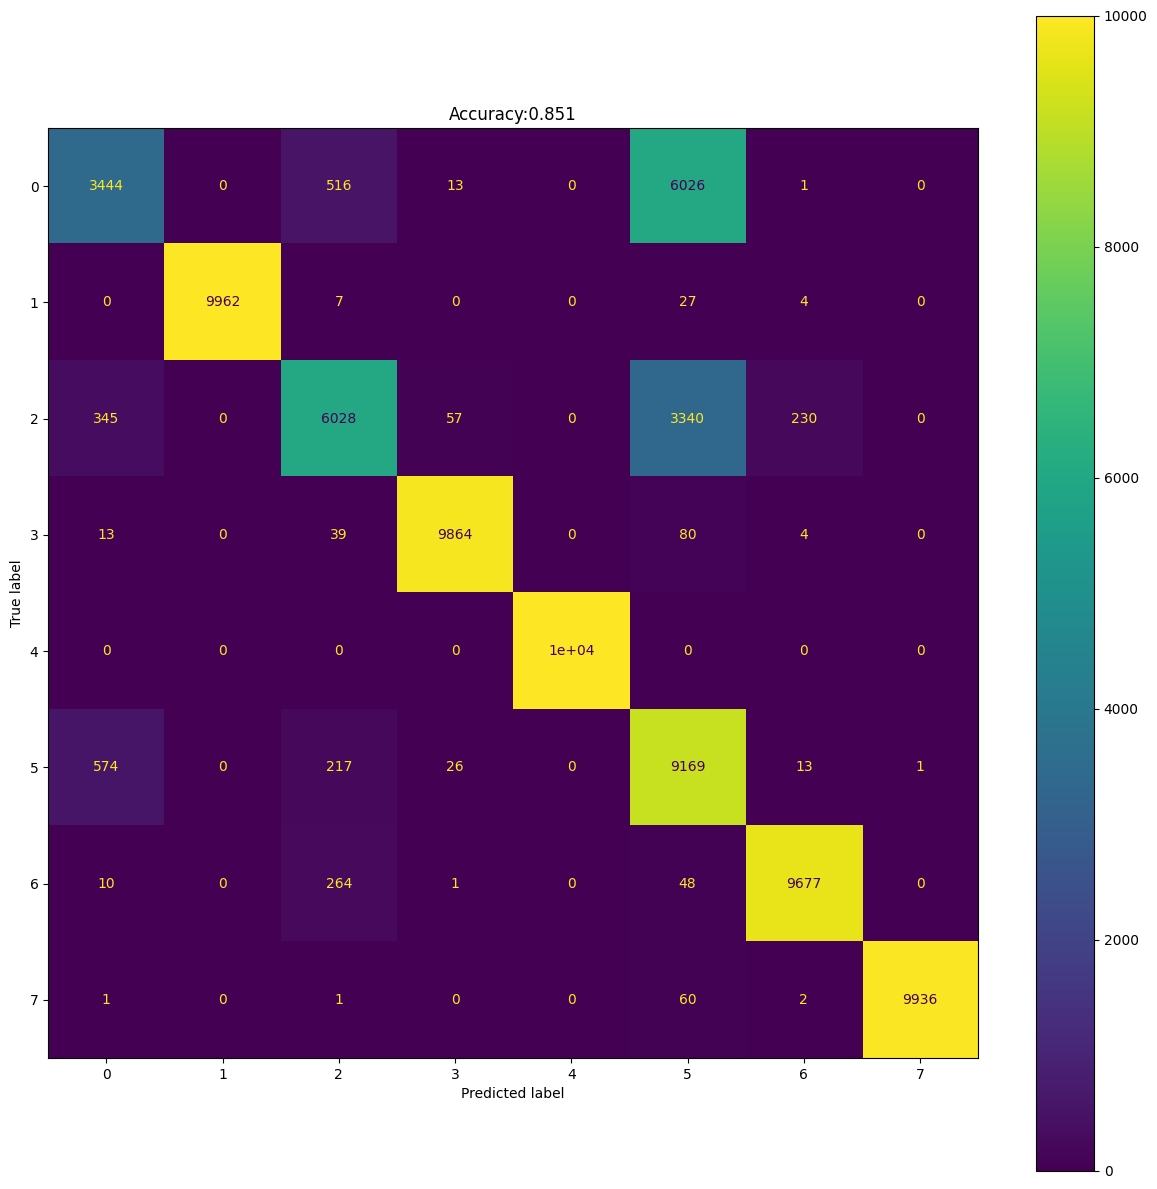

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')



## Cross-model Validation by applying Transfer Learning of other Device's Model

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3306 - accuracy: 0.8842
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2988 - accuracy: 0.8883
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2846 - accuracy: 0.8899
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2783 - accuracy: 0.8905
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2749 - accuracy: 0.8912
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2728 - accuracy: 0.8916
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2710 - accuracy: 0.8924
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2696 - accuracy: 0.8932
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2685 - accuracy: 0.8928
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - los

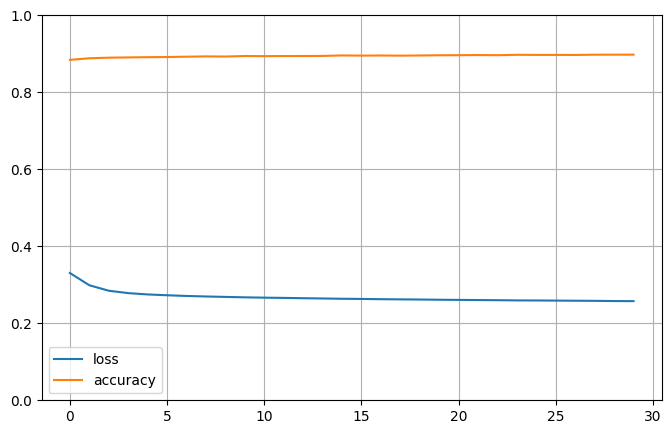

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2578 - accuracy: 0.8978
test loss, test acc: [0.25782346725463867, 0.8977749943733215]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 2 0 ... 7 7 7]
0
[[6737    0 1123    8    0 2132    0    0]
 [   0 9963   33    0    0    4    0    0]
 [ 545    1 8807   16    0  550   79    2]
 [  22    0   71 9877    0   29    1    0]
 [   0    0    0    0 9997    0    3    0]
 [2272    2 1098   24    0 6576    8   20]
 [  14    0   70    0    0   26 9890    0]
 [   5    0    3    0    0   17    0 9975]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     10000
           1       1.00      1.00      1.00     10000
           2       0.79      0.88      0.83     10000
           3       1.00      0.99      0.99     10000
           4       1.00      1.00      1.00     10000
           5       0.70      0.66      0.68     10000
           6       0.99      0.99      0.99     10000
           7       1.00      1.00      1.00     10000

    accuracy                           0.90     80000
   macro avg       0.90      0.90  

Test Accuracy:0.897775


Text(0.5, 1.0, 'Accuracy:0.898')

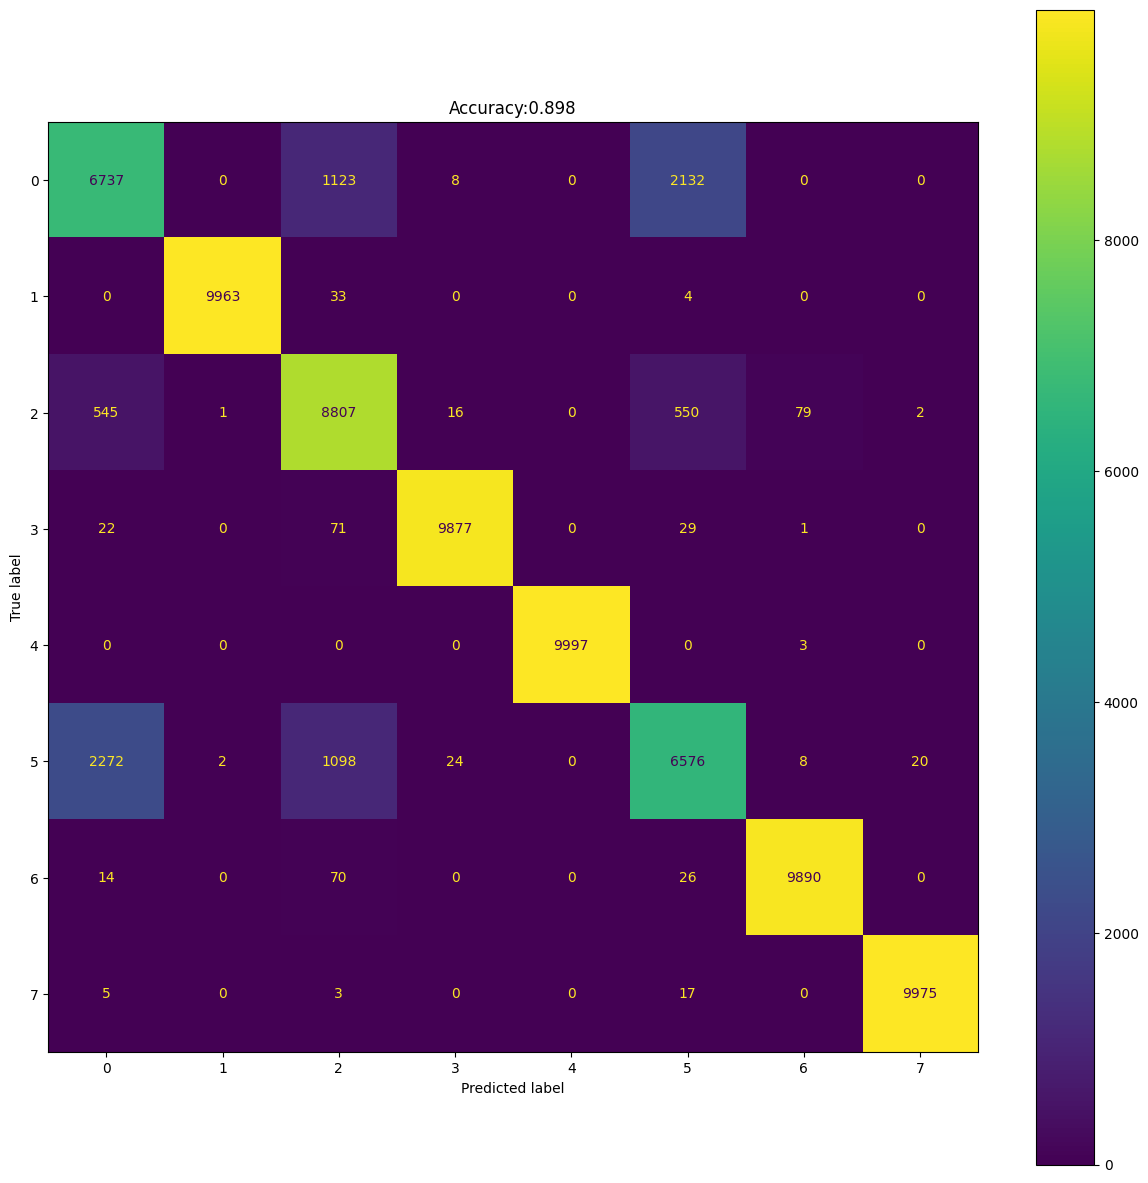

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')